Prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation à partir de relevés de la ville seattle
TARGET : SiteEnergyUseWN(kBtu) & GHGEmissions <br>
Obtenir un modèle pour l'énergie avec un R2 de plus de 0,75 sur le jeu de test et plus de 0,7 pour le CO2

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from category_encoders import MEstimateEncoder
import sklearn
sklearn.set_config(transform_output="pandas")
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

# 0. Nettoyage 

## 0.1 Import du df et nettoyage

In [93]:
def nettoyage():
    df = pd.read_csv('2016-building-energy-benchmarking.csv')
    # drop any multi family buildings, only non residential are targeted
    propertytype_dropped = ['Mid-Rise Multifamily','High-Rise Multifamily','Low-Rise Multifamily','Residence Hall']
    df = df[~df.PrimaryPropertyType.isin(propertytype_dropped)]
    buildingtype_dropped = ['Multifamily MR (5-9)','Multifamily HR (10+)','Multifamily LR (1-4)']
    df = df[~df.BuildingType.isin(buildingtype_dropped)]
    # col homogoneous or unable to use # here it is decided to drop the EnergyStar Score ? 
    cols_to_drop = ['CouncilDistrictCode','PropertyName','OSEBuildingID', 'City', 'State', 'DataYear', 'ZipCode', 'TaxParcelIdentificationNumber',
'YearsENERGYSTARCertified', 'Comments', 'DefaultData','Outlier','ENERGYSTARScore','Address']
    df.drop(columns=cols_to_drop, inplace=True)
    # too many missing data on these rows
    df.drop(index=[578,2670,30,1361,304],inplace=True)
    # renaming PropertyGFABuilding(s) to avoid bugs for the anova
    df.rename(columns={"PropertyGFABuilding(s)":"PropertyGFABuildings"}, inplace=True)
    # SiteEUIWN(kBtu/sf) imputing data by the coeff diff between WN and not WN
    df.loc[563,'SiteEUIWN(kBtu/sf)'] = df['SiteEUIWN(kBtu/sf)'].mean() / df['SiteEUI(kBtu/sf)'].mean() * 39.5
    df.loc[563,'SiteEnergyUseWN(kBtu)'] = df['SiteEnergyUse(kBtu)'].mean() / df['SiteEnergyUseWN(kBtu)'].mean() * 5177270.5
    # LargestPropertyUseType  not filled in , imputing by research on the activity of the company
    df.loc[1147,'LargestPropertyUseType'] = 'Hotel'
    df.loc[2414,'LargestPropertyUseType'] = 'Office'
    df.loc[2459,'LargestPropertyUseType'] = 'Restaurant'
    df.loc[353,'LargestPropertyUseType'] = 'Self-Storage Facility'
    # LargestPropertyUseTypeGFA not filled in, imputing the real GFA if one building else dividing totalGFA by number of buildings
    df.loc[1147,'LargestPropertyUseTypeGFA'] = 61721
    df.loc[2414,'LargestPropertyUseTypeGFA'] = 48350
    df.loc[2459,'LargestPropertyUseTypeGFA'] = 28800
    df.loc[353,'LargestPropertyUseTypeGFA'] = 55722
    # missing data from compliance
    idx_missingdata = df[df['ComplianceStatus'] ==  'Missing Data'].index
    df.drop(index=idx_missingdata, inplace=True)
    # fixing typos issues within the neighborhood column
    df.Neighborhood = df.Neighborhood.map(lambda x: x.lower())
    df.loc[3370,'Neighborhood'] = 'delridge'
    df.loc[1328,'PrimaryPropertyType'] = 'Hotel'
    # pour les WN non renseignés, imputation par multiplication de leur normal par le ratio de la moyenne
    for idx in df[df['SiteEUIWN(kBtu/sf)'] == 0].index : 
        df.loc[idx,'SiteEUIWN(kBtu/sf)'] = (df['SiteEUIWN(kBtu/sf)'].mean() / df['SiteEUI(kBtu/sf)'].mean()) * df.loc[idx,'SiteEUI(kBtu/sf)']
    # GFA columns : imputing NaN by 0 
    df['SecondLargestPropertyUseTypeGFA'] = df['SecondLargestPropertyUseTypeGFA'].fillna(0)
    df['ThirdLargestPropertyUseTypeGFA'] = df['ThirdLargestPropertyUseTypeGFA'].fillna(0)
    # SiteEnergyUseWN not filled in , mean imputing because weathered was filled in
    for idx in df[df['SiteEnergyUseWN(kBtu)'] == 0].index:
        df.loc[idx,'SiteEnergyUseWN(kBtu)'] = (df['SiteEUIWN(kBtu/sf)'].mean() / df['SiteEUI(kBtu/sf)'].mean()) * df.loc[idx,'SiteEnergyUse(kBtu)']
    # incorrect number of buildings of 0 
    idx_build0 = df[df.NumberofBuildings == 0].index
    for idx in idx_build0:
        df.loc[idx,'NumberofBuildings'] = 1
    return df

In [96]:
def preprocess(df):
    # skyscraper feature 
    df['skyscraper'] = df.NumberofFloors > 8 
    # OH functions ,if it is labo or a campus/univeristy or an hospital

    # laboratoire ? 
    def is_labo(x):
        if x['PrimaryPropertyType'] == 'Laboratory':
            return 1
        elif x['LargestPropertyUseType'] == 'Laboratory'  :
            return 1
        else :
            return 0
            
    df['is_laboratory'] = df.apply(is_labo, axis=1)

    # campus ou université ? 
    def is_campus(x):
        if x['BuildingType'] == 'Campus':
            return 1
        elif x['PrimaryPropertyType'] == 'University':
            return 1
        else :
            return 0 
            
    df['is_campus'] = df.apply(is_campus, axis=1)

    # hopital ? 
    def is_hospital(x):
        if x == 'Hospital':
            return 1
        else :
            return 0 
    #df['is_hospital'] = df.PrimaryPropertyType.map(is_hospital)
    #df.loc[2482, 'is_hospital'] = False # cas particulier
    
    # decennie est bof, essayer par trentaine d'année  ? 
    df['decennie'] = df.YearBuilt.map(lambda x :  (x-1900) // 10 )

    # calcul du pourcentage de source d'énergie
    def p_gas(x):
        if x['SiteEnergyUseWN(kBtu)'] != 0:
            return x['NaturalGas(kBtu)'] / x['SiteEnergyUseWN(kBtu)'] *100
        else : 
            return 0
    df['p_gas'] = df.apply(p_gas,axis=1)
    
    def p_elec(x):
        if x['SiteEnergyUseWN(kBtu)'] != 0:
            return x['Electricity(kBtu)'] / x['SiteEnergyUseWN(kBtu)'] *100
        else : 
            return 0
    df['p_elec'] = df.apply(p_elec,axis=1)
    def p_steam(x):
        if x['SiteEnergyUseWN(kBtu)'] != 0:
            return x['SteamUse(kBtu)'] / x['SiteEnergyUseWN(kBtu)'] *100
        else : 
            return 0
    df['p_steam'] = df.apply(p_steam,axis=1)
    # colonne de différence entre WN et normal
    df['WN_ratio'] = df['SiteEUIWN(kBtu/sf)'] / df['SiteEUI(kBtu/sf)']
    # get_dummies sur largestype
    #df = pd.get_dummies(df,columns=['LargestPropertyUseType'])
    # outlier ? 35 ? 
    df.drop(index=[3274,35], inplace = True)
    return df

In [97]:
df=preprocess(nettoyage())

## 0.2 Modification des Use Type et GFA's 

In [99]:
# colonnes sur lesquelles on va transformer
cols_to_transform = ['LargestPropertyUseType','LargestPropertyUseTypeGFA','SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA']
# DataFrame de travail
df_merging = df[cols_to_transform].copy()

In [100]:
# bins
list_type = ['Data Center','Fitness Center/Health Club/Gym','Office', 'Non-Refrigerated Warehouse', 'K-12 School', 'Retail Store',
       'Other', 'Hotel', 'Worship Facility', 'Distribution Center',
       'Supermarket/Grocery Store', 'Medical Office', 'Other - Recreation',
       'Parking', 'Self-Storage Facility', 'College/University',
       'Other - Entertainment/Public Assembly', 'Senior Care Community',
       'Laboratory', 'Restaurant', 'Refrigerated Warehouse',
       'Social/Meeting Hall', 'Hospital (General Medical & Surgical)',
       'Multifamily Housing', 'Manufacturing/Industrial Plant',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Strip Mall'] 
# mapping des colonnes UseType avec la liste de dessus
def categs1(x):
    if x in list_type:
        return x
    else :
        return 'Other'
df_merging['categs1'] = df_merging.LargestPropertyUseType.map(categs1)

def categs2(x):
    if x in list_type:
        return x
    elif x!= 0 :
        return 'Other'
df_merging['categs2'] = df_merging.SecondLargestPropertyUseType.map(categs2)

def categs3(x):
    if x in list_type:
        return x
    elif x!= 0 :
        return 'Other'
df_merging['categs3'] = df_merging.ThirdLargestPropertyUseType.map(categs3)

In [101]:
# OH 
df_merging = pd.get_dummies(df_merging,columns=['categs1'])
# liste des colonnes OH'ed
largest_cols = []
for col in df_merging.columns : 
    if 'categs1_' in col:
        largest_cols.append(col)
# !!! code dégueu :  boucle qui assigne la valeur GFA au type d'Use
for col in largest_cols:
    def transformGFA(x):
        if x[col] == True:
            return x['LargestPropertyUseTypeGFA']
        else : 
            return 0 
    df_merging[col+'1'] = df_merging.apply(transformGFA, axis=1)

In [102]:
# belote pour le second

df_merging = pd.get_dummies(df_merging,columns=['categs2'])

second_cols = []
for col in df_merging.columns : 
    if 'categs2_' in col:
        second_cols.append(col)
for col in second_cols:
    def secondtransformGFA(x):
        if x[col] == True:
            return x['SecondLargestPropertyUseTypeGFA']
        else : 
            return 0 
    df_merging[col+'2'] = df_merging.apply(secondtransformGFA, axis=1)

In [103]:
# rebelote , faire une fonction serait pas mal ....
df_merging = pd.get_dummies(df_merging,columns=['categs3'])

third_cols = []
for col in df_merging.columns : 
    if 'categs3_' in col:
        third_cols.append(col)
for col in third_cols:
    def thirdtransformGFA(x):
        if x[col] == True:
            return x['ThirdLargestPropertyUseTypeGFA']
        else : 
            return 0 
    df_merging[col+'3'] = df_merging.apply(thirdtransformGFA, axis=1)

In [104]:
# somme des valeurs des GFa/UseType en une colonne
for categ in list_type:
        if 'categs3_'+categ+'3' in df_merging.columns :
            if 'categs1_'+categ+'1' in df_merging.columns:
                if 'categs2_'+categ+'2' in df_merging.columns:
                    df_merging[categ] = df_merging['categs1_'+categ+'1'] +  df_merging['categs2_'+categ+'2'] + df_merging['categs3_'+categ+'3']
                else : 
                    df_merging[categ] =  df_merging['categs1_'+categ+'1'] + df_merging['categs3_'+categ+'3']
            elif 'categs2_'+categ+'2' in df_merging.columns:  
                    df_merging[categ] = df_merging['categs2_'+categ+'2'] + df_merging['categs3_'+categ+'3']
            else : 
                df_merging[categ] = df_merging['categs3_'+categ+'3']
        elif 'categs2_'+categ+'2' in df_merging.columns : 
            if 'categs1_'+categ+'1' in df_merging.columns:
                df_merging[categ] = df_merging['categs1_'+categ+'1'] +  df_merging['categs2_'+categ+'2']
            else : 
                df_merging[categ] = df_merging['categs2_'+categ+'2']
        else :
            df_merging[categ] = df_merging['categs1_'+categ+'1'] 

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_4044\2245526919.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merging[categ] = df_merging['categs1_'+categ+'1'] +  df_merging['categs2_'+categ+'2'] + df_merging['categs3_'+categ+'3']
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_4044\2245526919.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merging[categ] = df_merging['categs1_'+categ+'1'] +  df_merging['categs2_'+categ+'2'] + df_merging['categs3_'+categ+'3']
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_

In [105]:
# ajout de ces colonnes au df principal
df = df.merge(df_merging[list_type], left_index=True, right_index=True, how='outer')

# 1. EDA

In [24]:
df.describe(include ='all')

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,Senior Care Community,Laboratory,Restaurant,Refrigerated Warehouse,Social/Meeting Hall,Hospital (General Medical & Surgical),Multifamily Housing,Manufacturing/Industrial Plant,"Repair Services (Vehicle, Shoe, Locksmith, etc)",Strip Mall
count,1623,1623,1623,1623.000000,1623,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,...,1623.000000,1623.000000,1623.000000,1623.000000,1623.000000,1.623000e+03,1623.000000,1623.000000,1623.000000,1623.000000
unique,5,20,1619,NaN,13,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NonResidential,Small- and Mid-Sized Office,South Park,NaN,downtown,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1433,291,2,NaN,356,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,4.354282,NaN,47.615395,-122.333076,1961.868762,1.105977,4.154652,...,1454.220579,1043.162046,581.269871,479.824399,184.394948,4.276194e+03,914.300062,212.905730,164.792976,320.123845
std,NaN,NaN,NaN,2.204313,NaN,0.048115,0.024540,32.725920,1.174055,6.636882,...,21666.195795,11171.623252,4063.564915,7927.631642,2170.424024,6.611172e+04,12829.145674,3973.460564,2508.132536,6018.664487
min,NaN,NaN,NaN,1.000000,NaN,47.499170,-122.411820,1900.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,2.000000,NaN,47.584690,-122.343260,1930.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,4.000000,NaN,47.612170,-122.333050,1965.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,NaN,7.000000,NaN,47.648655,-122.322110,1989.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000


Valeurs Nulles

In [8]:
# to drop : OSEBuildingID, City, State, DataYear, ZipCode, TaxParcelIdentificationNumber,
#       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
#       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
#       'YearsENERGYSTARCertified', 'Comments'
# pending : Adress
# ? ? : PropertyName, 
# To transform : ?  : Neighborhood, Latitude, Longitude, by a K-means ? 
# YearBuilt : refaire des catégories ( ancien batiment, ? ,  récent, neuf) ? 
# NumberofBuildings  , regarder si c'est proportionnel
# 

## 1.1 Analyse Univariée

Number of Floors

In [40]:
df.NumberofFloors.value_counts()

NumberofFloors
1     464
2     390
3     260
4     140
5     101
6      83
7      33
8      22
10     18
11     18
0      12
14      9
12      9
9       7
13      7
15      5
42      5
19      5
17      4
16      3
21      3
22      3
23      3
29      3
18      3
20      3
24      3
25      3
33      3
36      2
34      2
41      2
46      1
99      1
27      1
76      1
56      1
30      1
28      1
55      1
63      1
37      1
49      1
47      1
39      1
Name: count, dtype: int64

<Axes: >

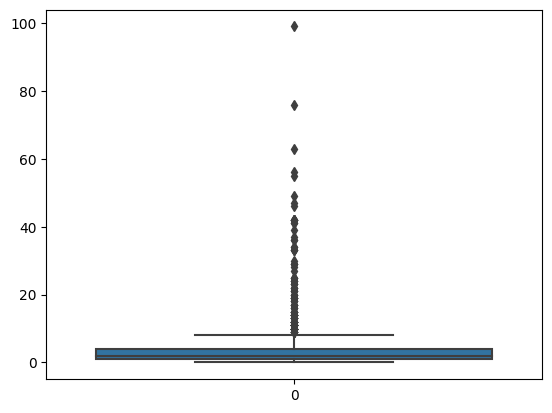

In [41]:
sns.boxplot(df.NumberofFloors)

In [43]:
df[df.NumberofFloors > 40 ].index

Index([2, 221, 222, 229, 231, 233, 256, 261, 271, 273, 292, 490, 559, 577,
       1359],
      dtype='int64')

Number of Buildings

In [11]:
df.NumberofBuildings.value_counts()

NumberofBuildings
1.0      1558
0.0        52
2.0        14
3.0        12
5.0         8
4.0         4
6.0         4
14.0        2
8.0         2
27.0        1
11.0        1
9.0         1
7.0         1
23.0        1
10.0        1
111.0       1
Name: count, dtype: int64

In [44]:
df[df.NumberofBuildings > 5].index

Index([ 105,  124,  128,  162,  167,  170,  364,  618, 1672, 1862, 1993, 2325,
       2901, 3168, 3274],
      dtype='int64')

PropertyGFA

{'whiskers': [<matplotlib.lines.Line2D at 0x206a12f2250>,
 'caps': [<matplotlib.lines.Line2D at 0x206a12af8d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x206a12f1310>],
 'medians': [<matplotlib.lines.Line2D at 0x206a13013d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x206a1301310>],
 'means': []}

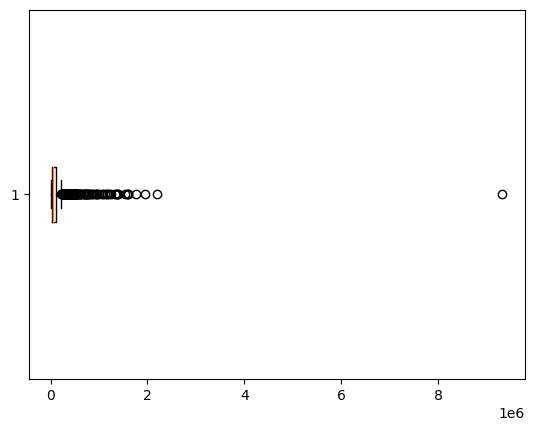

In [12]:
plt.boxplot(df.PropertyGFATotal, vert=False)

In [161]:
df[df.PropertyGFATotal > 1500000].sort_values(by='PropertyGFATotal')

,BuildingType,PrimaryPropertyType,PropertyName,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,...,Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity,is_laboratory,is_hospital,is_campus,decennie
273,NonResidential,Large Office,US Bank Centre,7,downtown,47.610540,-122.334660,1989,1.0,46,...,53668061.0,29380.699220,2938070.0,Compliant,530.18,0.35,0,0,0,8
155,NonResidential,Other,CenturyLink,2,greater duwamish,47.595440,-122.331590,1999,1.0,6,...,49439914.0,103175.179700,10317518.0,Compliant,892.63,0.56,0,0,0,9
490,NonResidential,Large Office,Russell Investments Center,7,downtown,47.607400,-122.337770,2005,1.0,42,...,55123924.0,3885.316895,388532.0,Compliant,481.06,0.30,0,0,0,10
292,NonResidential,Large Office,Two Union Square,7,downtown,47.610430,-122.332060,1989,1.0,56,...,46081813.0,25202.298830,2520230.0,Compliant,525.78,0.33,0,0,0,8
618,NonResidential,Hospital,Swedish First Hill,3,east,47.608951,-122.322402,1994,7.0,14,...,139354828.0,173161.203100,17316120.0,Compliant,12307.16,6.97,0,1,0,9
559,NonResidential,Large Office,Columbia Center - 2015,7,downtown,47.604540,-122.330720,1985,1.0,76,...,87851862.0,50857.632810,5085763.0,Compliant,882.56,0.45,0,0,0,8
1494,Campus,University,Entire Campus,3,east,47.610650,-122.317110,1939,1.0,2,...,61672821.0,529756.937500,52975694.0,Compliant,3243.48,1.47,0,0,1,3
3274,Campus,University,University of Washington - Seattle Campus,4,northeast,47.656440,-122.310410,1900,111.0,0,...,657074389.0,0.000000,0.0,Compliant,11140.56,1.20,0,0,1,0


PropertyGFAParking

In [14]:
df.PropertyGFAParking.value_counts()

PropertyGFAParking
0         1333
13320        3
10800        2
30000        2
25800        2
          ... 
115228       1
33921        1
44728        1
38400        1
85028        1
Name: count, Length: 326, dtype: int64

<Axes: >

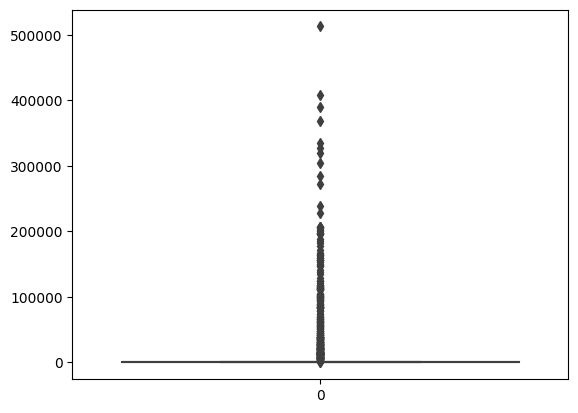

In [67]:
sns.boxplot(df['PropertyGFAParking'])

In [48]:
df[df.PropertyGFAParking >  200000 ].index

Index([  43,   77,  155,  163,  207,  212,  229,  271,  273,  292,  307,  338,
        492,  559,  577,  599, 2530, 3233],
      dtype='int64')

PropertyGFABuilding(s)

In [51]:
df[df['PropertyGFABuildings'] > 1500000].sort_values(by='PropertyGFABuildings', ascending=False).index

Index([3274, 1494, 618, 559, 490], dtype='int64')

SiteEUI(kBtu/sf)

<Axes: >

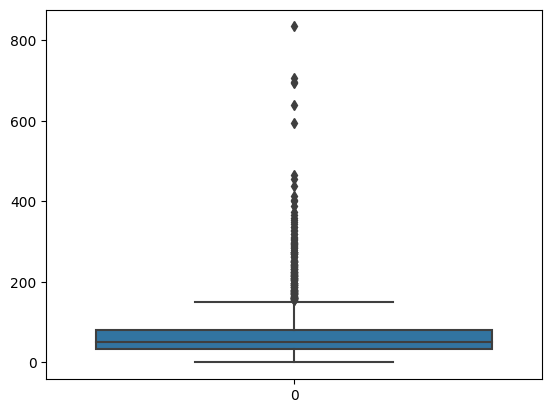

In [74]:
sns.boxplot(df['SiteEUI(kBtu/sf)'])

In [52]:
df[df['SiteEUI(kBtu/sf)'] > 500 ].sort_values(by='SiteEUI(kBtu/sf)', ascending=False).index

Index([240, 309, 809, 3203, 558, 3171], dtype='int64')

SiteEUIWN(kBtu/sf)

<Axes: >

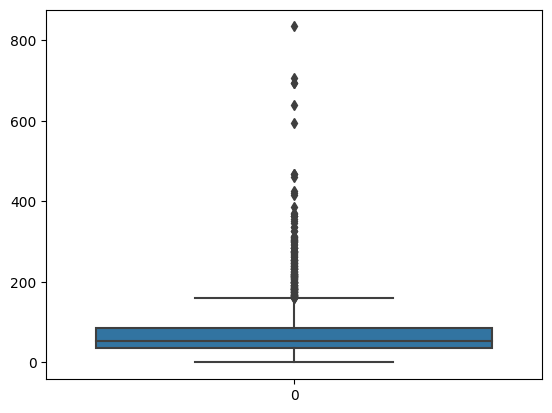

In [30]:
sns.boxplot(df['SiteEUIWN(kBtu/sf)'])

In [53]:
df[df['SiteEUIWN(kBtu/sf)'] > 500 ].sort_values(by='SiteEUIWN(kBtu/sf)', ascending=False).index

Index([240, 309, 3203, 809, 558, 3171], dtype='int64')

 'SiteEnergyUse(kBtu)', 

<Axes: >

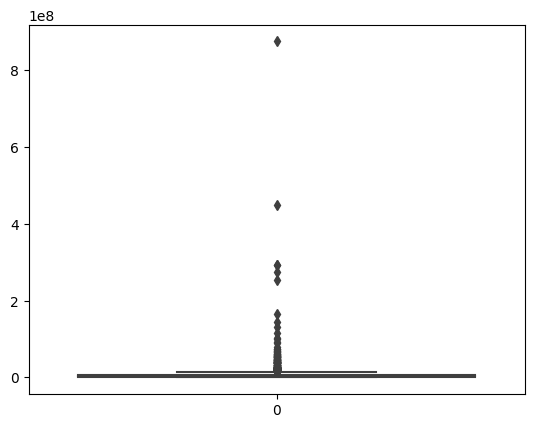

In [34]:
sns.boxplot(df['SiteEnergyUse(kBtu)'])

In [54]:
df[df['SiteEnergyUse(kBtu)'] > 200000000 ].sort_values(by='SiteEnergyUse(kBtu)', ascending=False).index

Index([3274, 35, 170, 618, 558, 124], dtype='int64')

'SteamUse(kBtu)'

<Axes: >

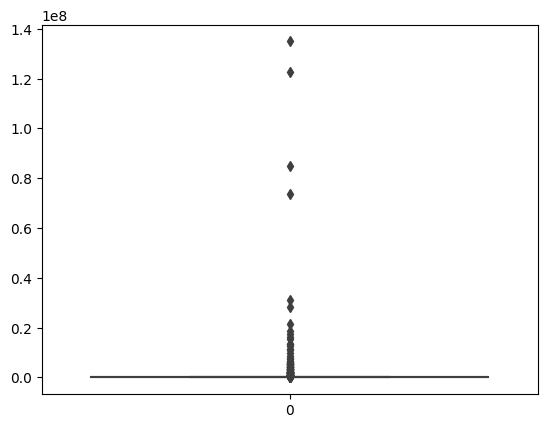

In [35]:
sns.boxplot(df['SteamUse(kBtu)'])

In [56]:
df[df['SteamUse(kBtu)'] > 20000000 ].sort_values(by='SteamUse(kBtu)', ascending=False).index

Index([618, 170, 3274, 3264, 3156, 262, 2], dtype='int64')

In [36]:
df[df['SteamUse(kBtu)'] == 0].shape

(1549, 46)

Electricity(kWh)

<Axes: >

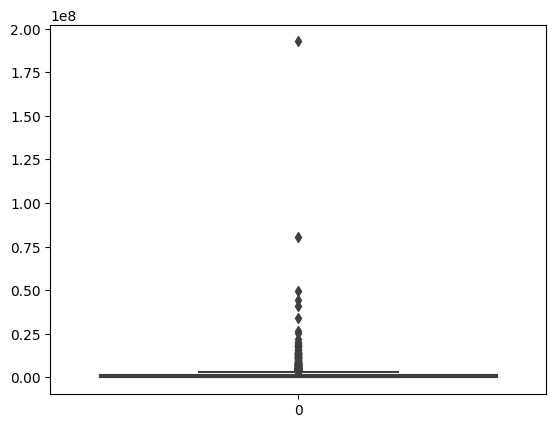

In [38]:
sns.boxplot(df["Electricity(kWh)"])

In [57]:
df[df['Electricity(kWh)'] > 25000000 ].sort_values(by='Electricity(kWh)', ascending=False).index

Index([3274, 558, 170, 35, 618, 124, 3264, 559], dtype='int64')

Natural Gas (therms and kBtu)

<Axes: >

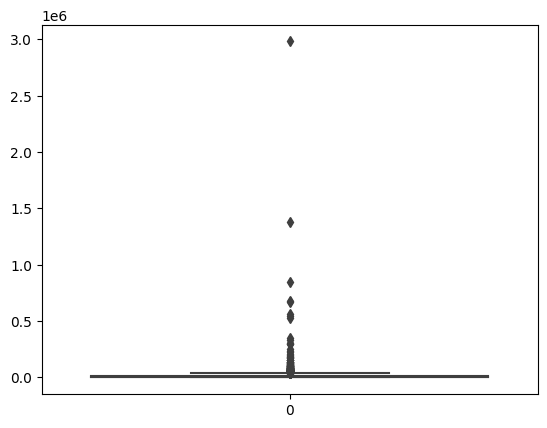

In [47]:
sns.boxplot(df['NaturalGas(therms)'])

In [58]:
df[df['NaturalGas(therms)'] > 500000 ].sort_values(by='NaturalGas(therms)', ascending=False).index

Index([35, 124, 167, 2325, 340, 1672, 1690, 1494], dtype='int64')

ComplianceStatus

In [104]:
df.ComplianceStatus.value_counts()

ComplianceStatus
Compliant                       1523
Error - Correct Default Data      86
Non-Compliant                     14
Name: count, dtype: int64

TotalGHGEmissions & GHGEmissionsIntensity

<Axes: >

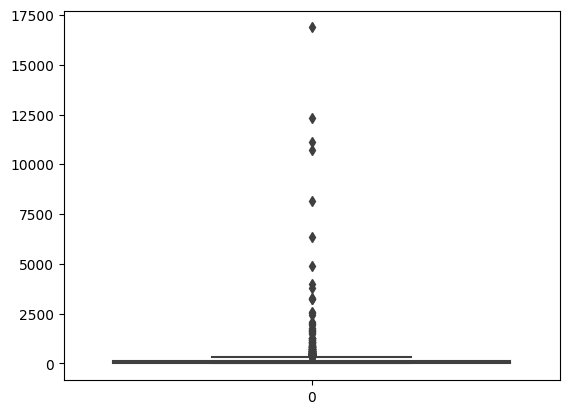

In [56]:
sns.boxplot(df['TotalGHGEmissions'])

In [59]:
df[df['TotalGHGEmissions'] > 5000 ].sort_values(by='TotalGHGEmissions', ascending=False).index

Index([35, 618, 3274, 170, 124, 3264], dtype='int64')

<Axes: >

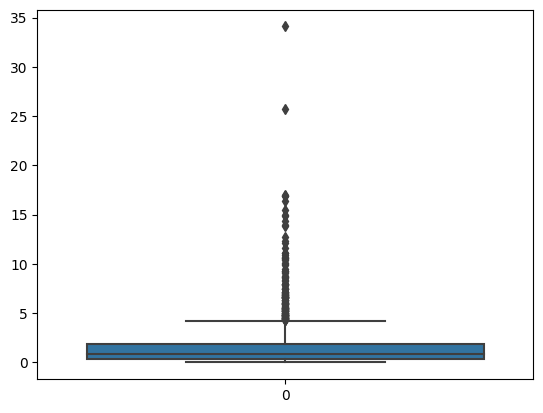

In [57]:
sns.boxplot(df['GHGEmissionsIntensity'])

In [62]:
df[df['GHGEmissionsIntensity'] > 14 ].sort_values(by='GHGEmissionsIntensity', ascending=False).index

Index([35, 809, 3373, 3365, 3264, 1817, 1279, 1753, 2380, 3156], dtype='int64')

<Axes: >

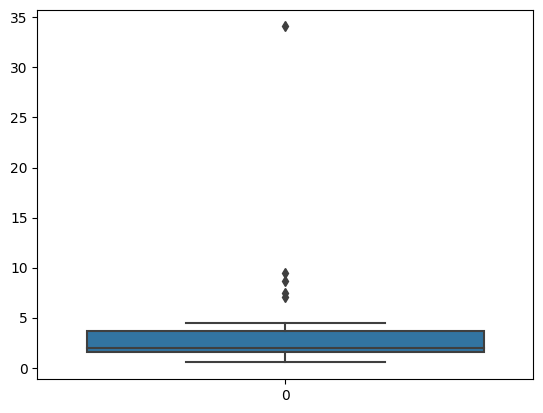

In [67]:
sns.boxplot(df[df.BuildingType.isin(['Campus','Hospital'])]['GHGEmissionsIntensity'].values)

In [106]:
df.PrimaryPropertyType.unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'K-12 School',
       'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Warehouse', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Distribution Center', 'Worship Facility',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'Office'], dtype=object)

In [93]:
df.loc[df.PrimaryPropertyType.isin(['Mixed Use Property'])].sort_values(by='GHGEmissionsIntensity', ascending = False)

,BuildingType,PrimaryPropertyType,PropertyName,Address,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
35,Campus,Mixed Use Property,Plant 2 Site,7755 E MARGINAL WAY S,2,GREATER DUWAMISH,47.53493,-122.31788,1992,1.0,...,4.483853e+08,4.716139e+08,0.0,4.410208e+07,150476283.0,2.979090e+06,297909000.0,Compliant,16870.98,34.09
2380,NonResidential,Mixed Use Property,Chandler's Cove - SEDO,901 Fairview Ave. N.,3,LAKE UNION,47.62774,-122.33384,1988,1.0,...,1.548068e+07,1.596084e+07,0.0,1.946760e+06,6642344.0,8.838336e+04,8838336.0,Compliant,515.71,14.89
47,NonResidential,Mixed Use Property,Mann Building,1401 3rd Avenue,7,DOWNTOWN,47.60886,-122.33744,1926,1.0,...,1.502620e+07,1.568374e+07,0.0,1.357696e+06,4632459.0,1.039374e+05,10393737.0,Compliant,584.31,11.12
373,NonResidential,Mixed Use Property,Seattle Art Museum,1300 1st Avenue,7,DOWNTOWN,47.60740,-122.33777,1991,1.0,...,5.296080e+07,5.373420e+07,17548416.0,1.023939e+07,34936812.0,4.755600e+03,475560.0,Compliant,1623.34,10.50
986,NonResidential,Mixed Use Property,Matador/Jak's Grill/8 Limbs Yoga/Fitness,4546 California Ave SW,1,SOUTHWEST,47.56147,-122.38638,1930,1.0,...,4.265815e+06,4.345884e+06,0.0,2.406832e+05,821211.0,3.444604e+04,3444604.0,Compliant,188.67,9.11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1839,NonResidential,Mixed Use Property,The Travelers Hotel,80 Yesler Way,7,DOWNTOWN,47.60195,-122.33516,1913,1.0,...,7.697713e+05,7.697713e+05,0.0,2.256070e+05,769771.0,0.000000e+00,0.0,Compliant,5.37,0.12
796,NonResidential,Mixed Use Property,U.S. BANK,2401 3RD AVE,7,DOWNTOWN,47.61543,-122.34651,1954,1.0,...,4.183485e+05,4.507802e+05,0.0,1.226109e+05,418348.0,0.000000e+00,0.0,Compliant,2.92,0.10
3041,NonResidential,Mixed Use Property,1700 Madison Apts. Bldg. 2,1700 E Madison St,3,Central,47.61608,-122.30967,2004,1.0,...,1.021755e+06,1.056508e+06,0.0,2.994591e+05,1021754.0,0.000000e+00,0.0,Compliant,7.12,0.07
2182,NonResidential,Mixed Use Property,JukeboxCity Building,1946-1952 1st Ave S,2,GREATER DUWAMISH,47.58452,-122.33370,1916,1.0,...,2.298564e+05,2.483349e+05,0.0,6.736710e+04,229857.0,0.000000e+00,0.0,Compliant,1.60,0.06


## 1.2 Analyse Bivariée

In [107]:
def boxplot_test(col,target, violin = False):
  print(f"\n Distribution de {target} et  {col}")
  freq_col = pd.DataFrame(df[[target,col]])
  freq_col[col] = freq_col[col].astype('str')
  print(df[col].value_counts())
  sns.color_palette("Set2")
  if violin :
    sns.violinplot(x=freq_col[target],y=freq_col[col], palette="pastel")
  else :
    sns.boxplot(x=freq_col[target],y=freq_col[col], palette="Set2",showfliers=False)
  plt.title(col)
  plt.show()

In [108]:
def scatter_test(col,target):
    sns.color_palette("Set2")
    freq_col = pd.DataFrame(df[[target,col]])
    sns.scatterplot(y=freq_col[target],x=freq_col[col])
    plt.title(col)
    plt.show()

In [1]:
# 'Latitude', 'Longitude', 
cols_num = [
       'SteamUse(kBtu)','Electricity(kBtu)',
       'NaturalGas(kBtu)','PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuildings']
cols_categ = ['Neighborhood','BuildingType', 'PrimaryPropertyType','YearBuilt', 'NumberofBuildings',
       'NumberofFloors','decennie']

ord_categ = ['NumberofFloors','decennie','YearBuilt']

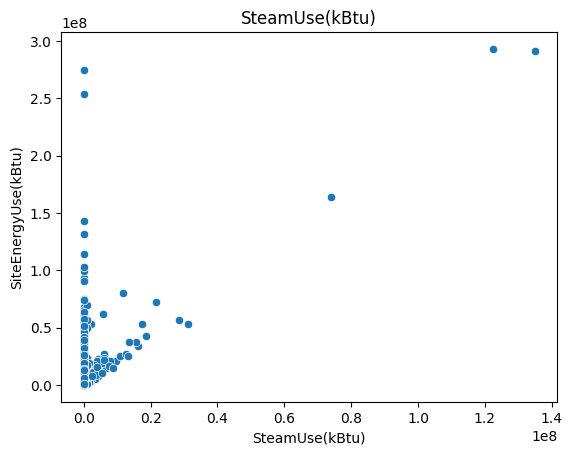

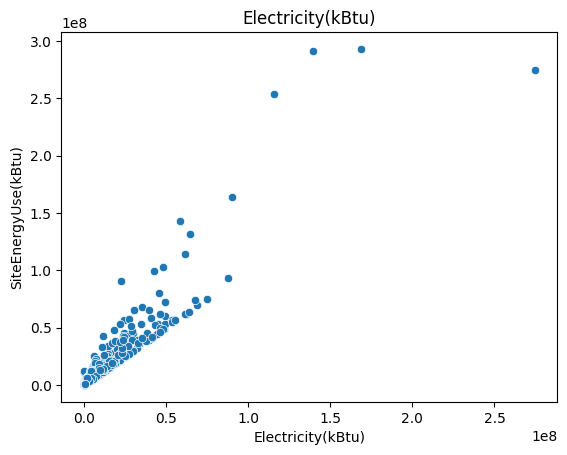

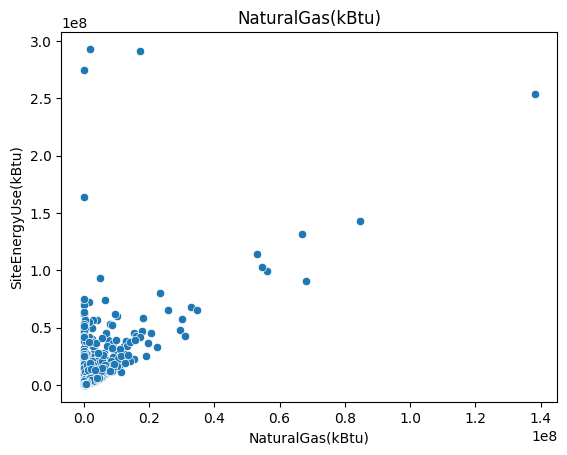

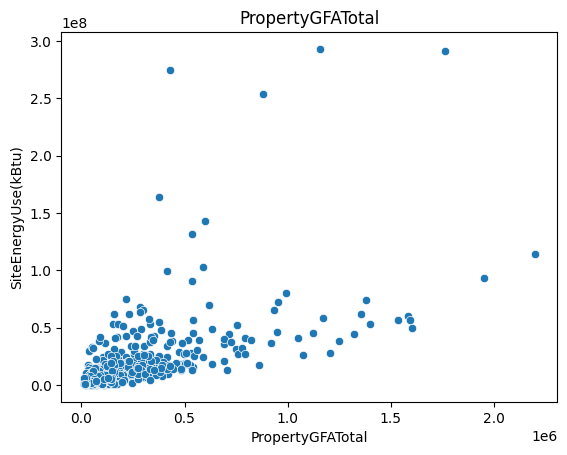

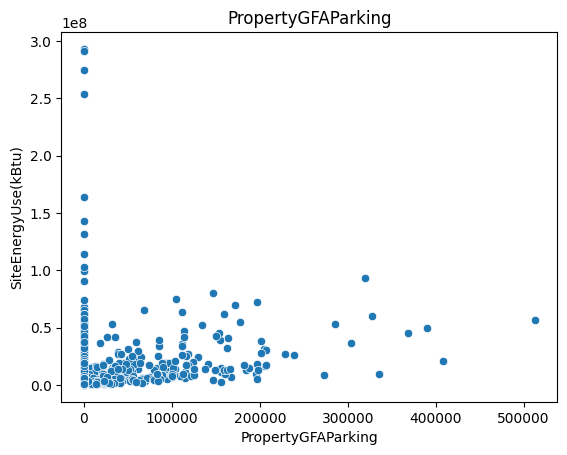

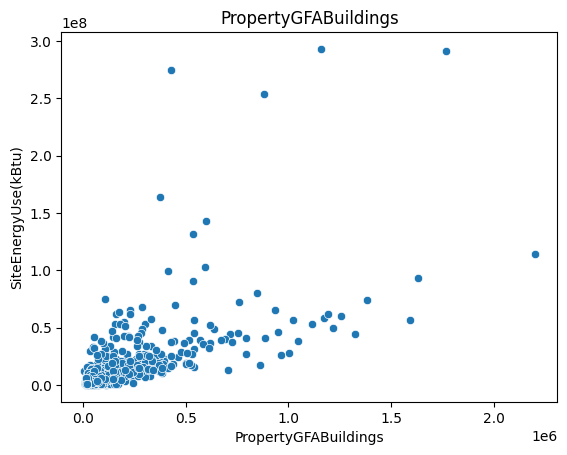

In [121]:
for col_num in cols_num : 
    scatter_test(col_num,'SiteEnergyUse(kBtu)')

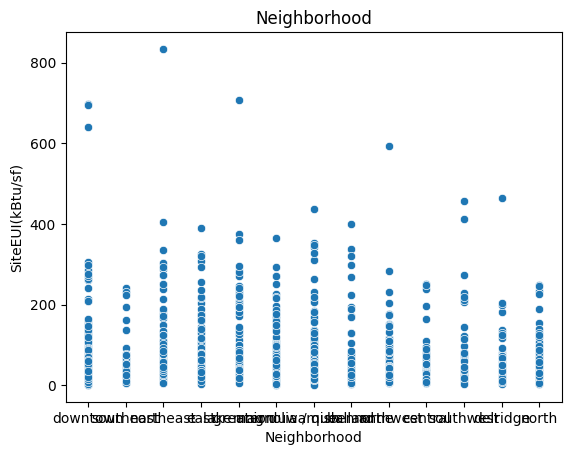

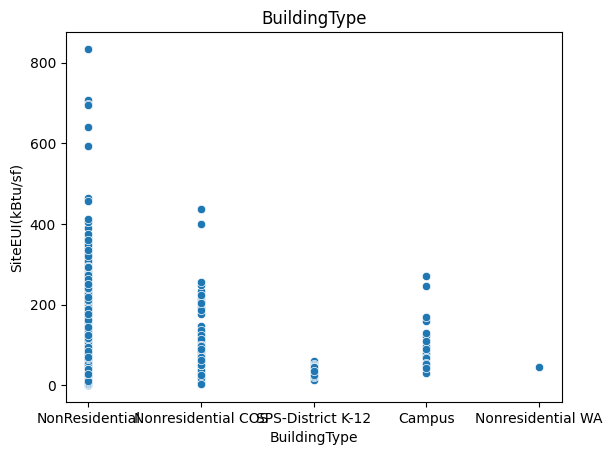

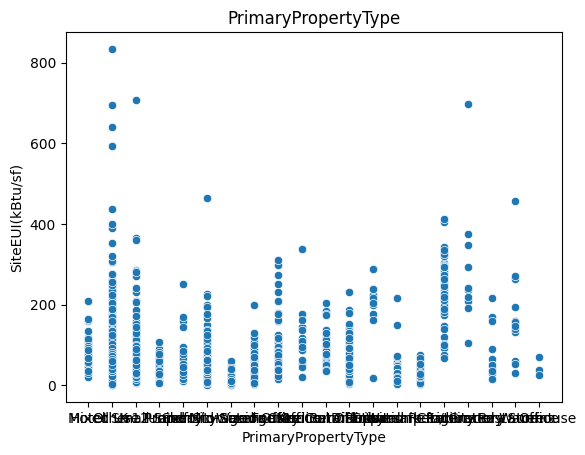

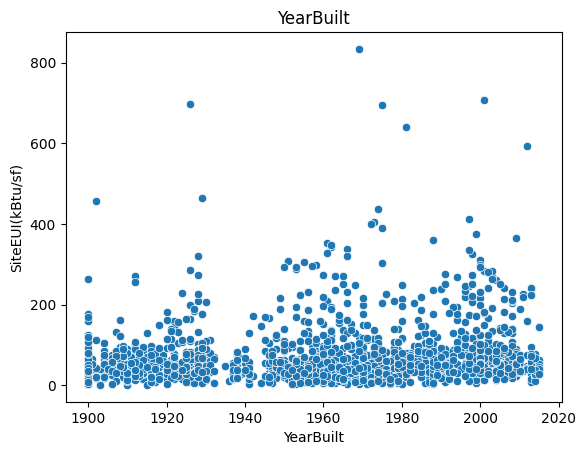

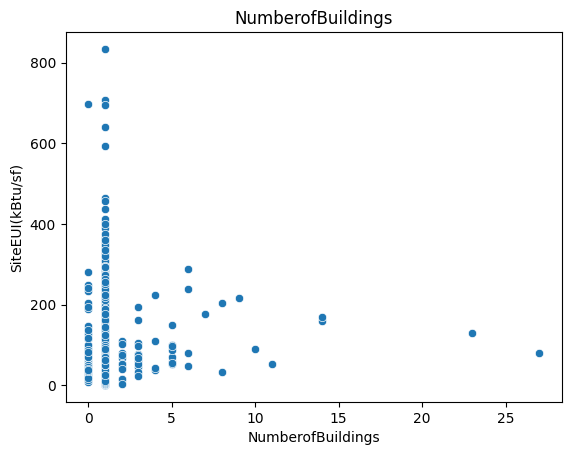

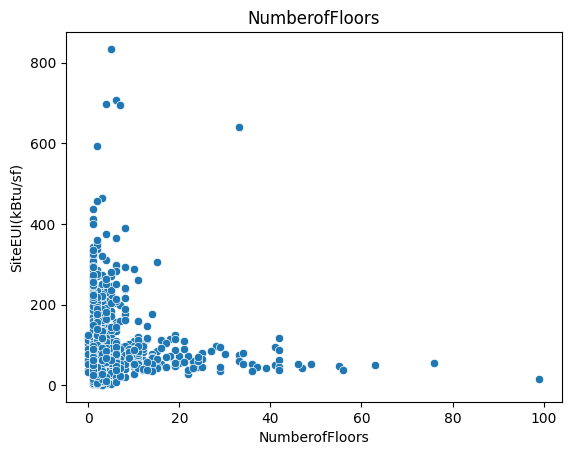

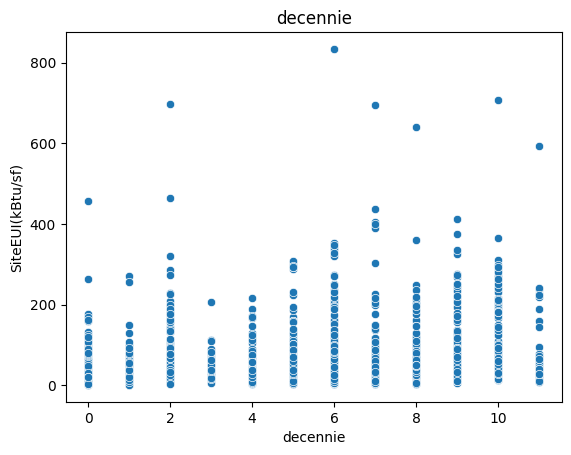

In [110]:
for col_categ in cols_categ : 
    scatter_test(col_categ,'SiteEUI(kBtu/sf)')


 Distribution de TotalGHGEmissions et  Neighborhood
Neighborhood
downtown                 356
greater duwamish         345
magnolia / queen anne    147
lake union               145
east                     118
northeast                112
northwest                 85
ballard                   68
north                     64
central                   52
delridge                  46
southeast                 45
southwest                 40
Name: count, dtype: int64


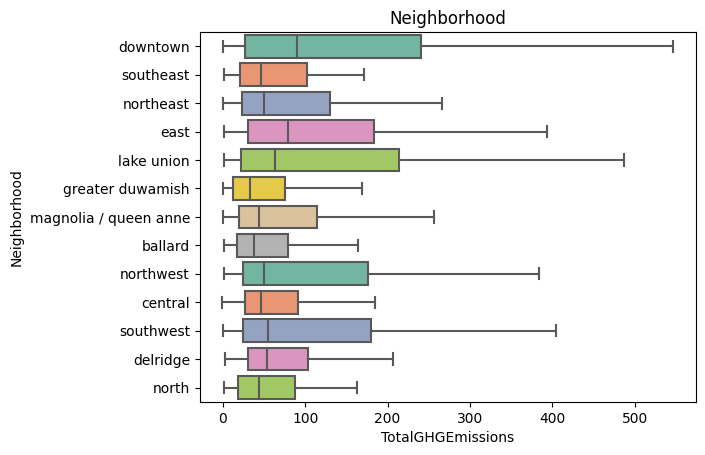


 Distribution de TotalGHGEmissions et  BuildingType
BuildingType
NonResidential        1433
Nonresidential COS      85
SPS-District K-12       83
Campus                  21
Nonresidential WA        1
Name: count, dtype: int64


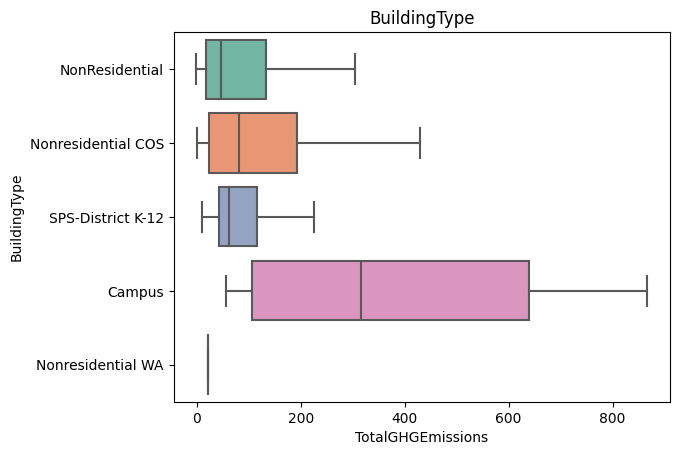


 Distribution de TotalGHGEmissions et  PrimaryPropertyType
PrimaryPropertyType
Small- and Mid-Sized Office    291
Other                          248
Warehouse                      187
Large Office                   173
K-12 School                    124
Mixed Use Property             111
Retail Store                    91
Hotel                           77
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      23
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: count, dtype: int64


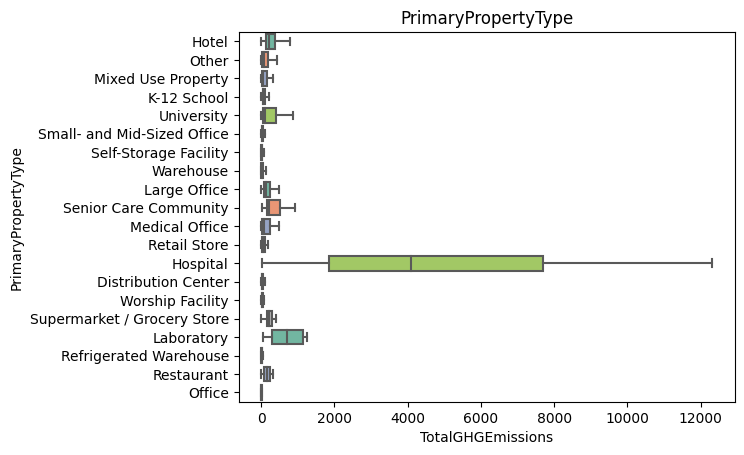


 Distribution de TotalGHGEmissions et  YearBuilt
YearBuilt
1900    45
2000    34
1970    32
1910    30
1960    30
        ..
1939     2
1901     2
1942     2
1936     1
1935     1
Name: count, Length: 113, dtype: int64


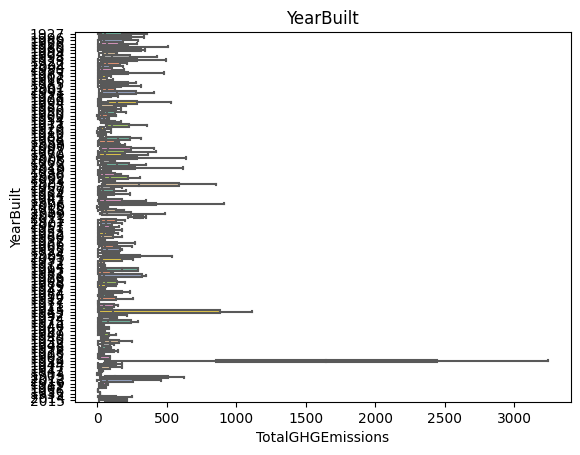


 Distribution de TotalGHGEmissions et  NumberofBuildings
NumberofBuildings
1.0     1520
0.0       51
2.0       14
3.0       12
5.0        8
4.0        4
6.0        4
14.0       2
8.0        2
27.0       1
11.0       1
9.0        1
7.0        1
23.0       1
10.0       1
Name: count, dtype: int64


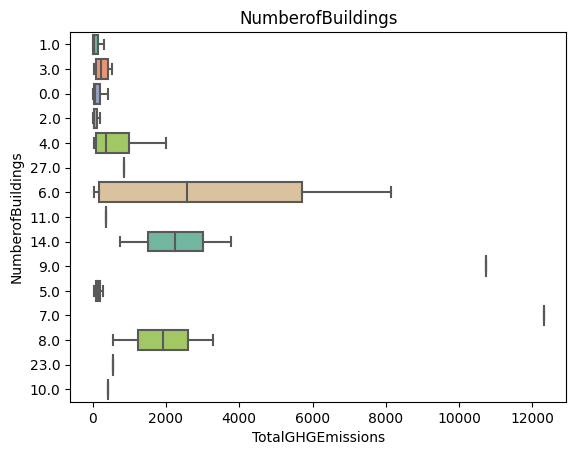


 Distribution de TotalGHGEmissions et  NumberofFloors
NumberofFloors
1     457
2     385
3     255
4     140
5     101
6      83
7      33
8      22
10     18
11     18
0      11
14      9
12      9
9       7
13      7
42      5
19      5
15      5
17      4
16      3
21      3
22      3
23      3
29      3
18      3
20      3
24      3
25      3
33      3
36      2
34      2
41      2
46      1
99      1
27      1
76      1
56      1
30      1
28      1
55      1
63      1
37      1
49      1
47      1
39      1
Name: count, dtype: int64


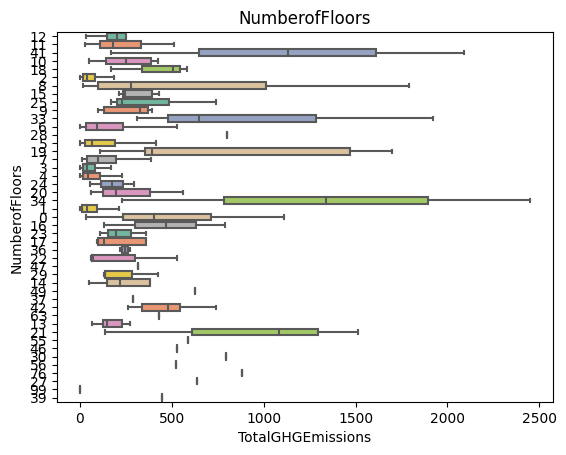


 Distribution de TotalGHGEmissions et  decennie
decennie
6     225
10    198
8     166
2     165
7     163
5     162
9     145
0     121
1     110
4      62
3      53
11     53
Name: count, dtype: int64


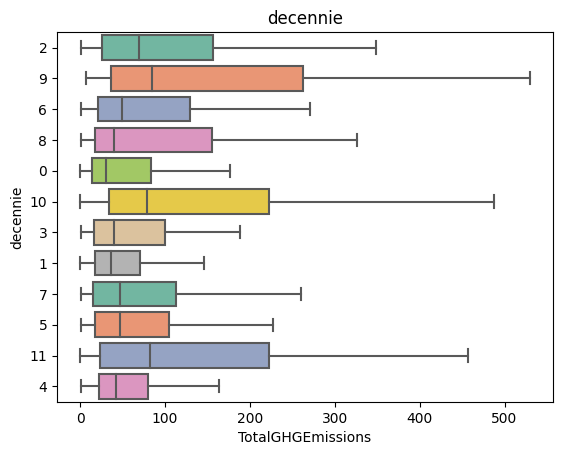

In [111]:
for col_categ in cols_categ : 
    boxplot_test(col_categ,'TotalGHGEmissions')

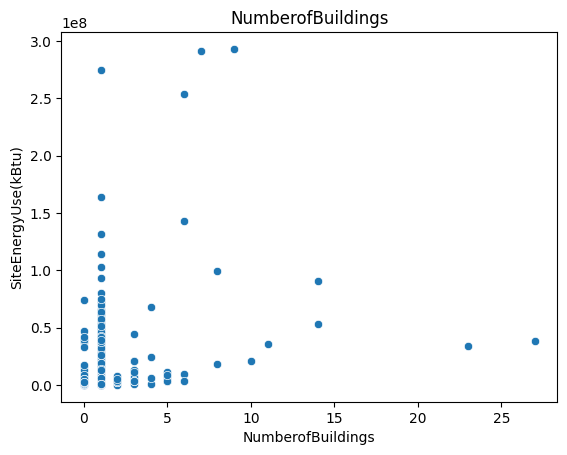

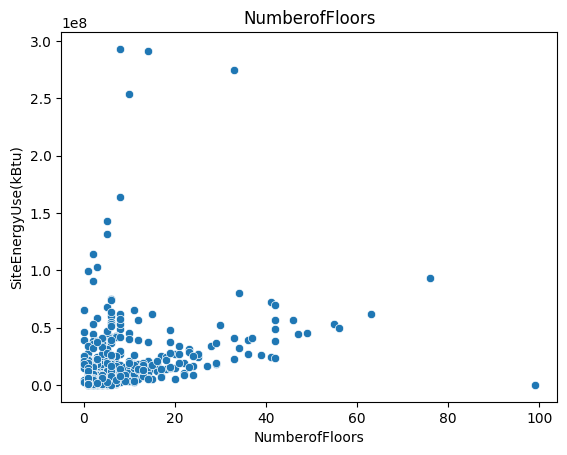

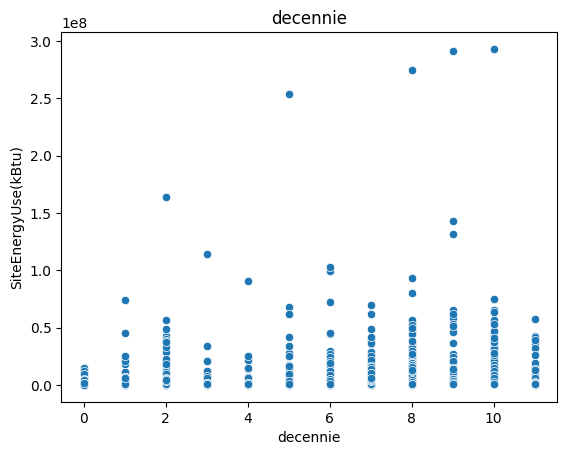

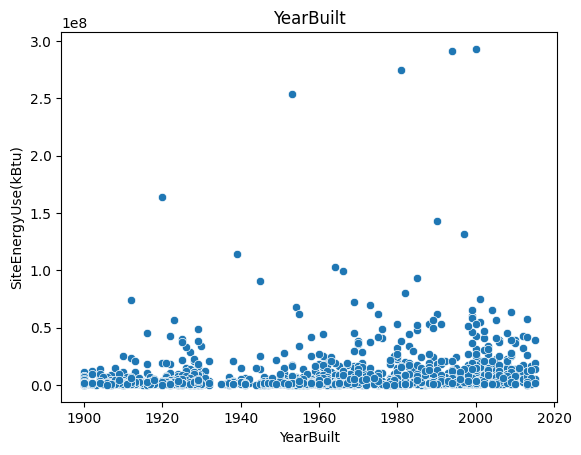

In [112]:
for col_ord in ord_categ : 
    scatter_test(col_ord,'SiteEnergyUse(kBtu)')

In [114]:
larg_columns = ['LargestPropertyUseType_Adult Education',
       'LargestPropertyUseType_Automobile Dealership',
       'LargestPropertyUseType_Bank Branch',
       'LargestPropertyUseType_College/University',
       'LargestPropertyUseType_Courthouse',
       'LargestPropertyUseType_Data Center',
       'LargestPropertyUseType_Distribution Center',
       'LargestPropertyUseType_Financial Office',
       'LargestPropertyUseType_Fire Station',
       'LargestPropertyUseType_Fitness Center/Health Club/Gym',
       'LargestPropertyUseType_Food Service',
       'LargestPropertyUseType_Hospital (General Medical & Surgical)',
       'LargestPropertyUseType_Hotel', 'LargestPropertyUseType_K-12 School',
       'LargestPropertyUseType_Laboratory', 'LargestPropertyUseType_Library',
       'LargestPropertyUseType_Lifestyle Center',
       'LargestPropertyUseType_Manufacturing/Industrial Plant',
       'LargestPropertyUseType_Medical Office',
       'LargestPropertyUseType_Movie Theater',
       'LargestPropertyUseType_Multifamily Housing',
       'LargestPropertyUseType_Museum',
       'LargestPropertyUseType_Non-Refrigerated Warehouse',
       'LargestPropertyUseType_Office', 'LargestPropertyUseType_Other',
       'LargestPropertyUseType_Other - Education',
       'LargestPropertyUseType_Other - Entertainment/Public Assembly',
       'LargestPropertyUseType_Other - Lodging/Residential',
       'LargestPropertyUseType_Other - Mall',
       'LargestPropertyUseType_Other - Public Services',
       'LargestPropertyUseType_Other - Recreation',
       'LargestPropertyUseType_Other - Restaurant/Bar',
       'LargestPropertyUseType_Other - Services',
       'LargestPropertyUseType_Other - Utility',
       'LargestPropertyUseType_Other/Specialty Hospital',
       'LargestPropertyUseType_Parking',
       'LargestPropertyUseType_Performing Arts',
       'LargestPropertyUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'LargestPropertyUseType_Police Station',
       'LargestPropertyUseType_Pre-school/Daycare',
       'LargestPropertyUseType_Prison/Incarceration',
       'LargestPropertyUseType_Refrigerated Warehouse',
       'LargestPropertyUseType_Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'LargestPropertyUseType_Residence Hall/Dormitory',
       'LargestPropertyUseType_Residential Care Facility',
       'LargestPropertyUseType_Restaurant',
       'LargestPropertyUseType_Retail Store',
       'LargestPropertyUseType_Self-Storage Facility',
       'LargestPropertyUseType_Senior Care Community',
       'LargestPropertyUseType_Social/Meeting Hall',
       'LargestPropertyUseType_Strip Mall',
       'LargestPropertyUseType_Supermarket/Grocery Store',
       'LargestPropertyUseType_Urgent Care/Clinic/Other Outpatient',
       'LargestPropertyUseType_Wholesale Club/Supercenter',
       'LargestPropertyUseType_Worship Facility']

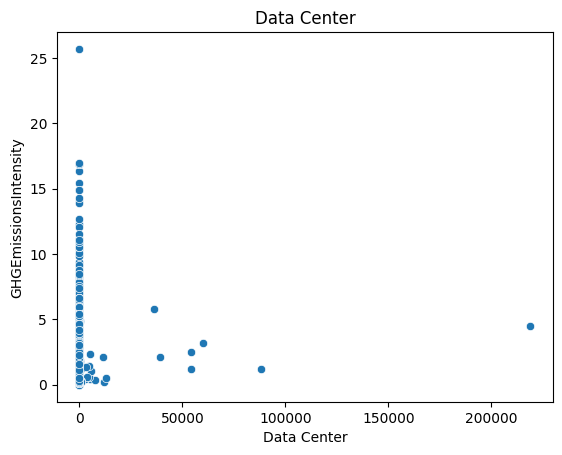

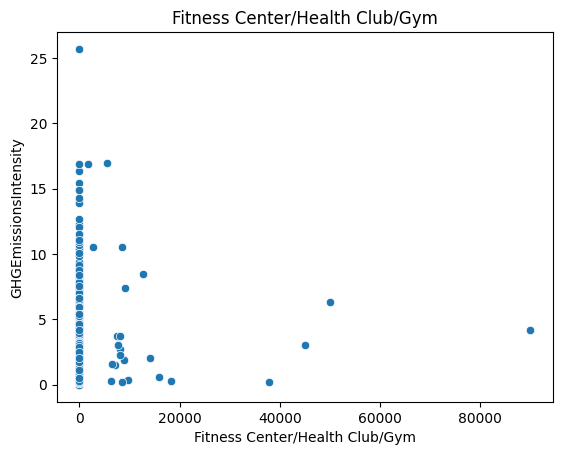

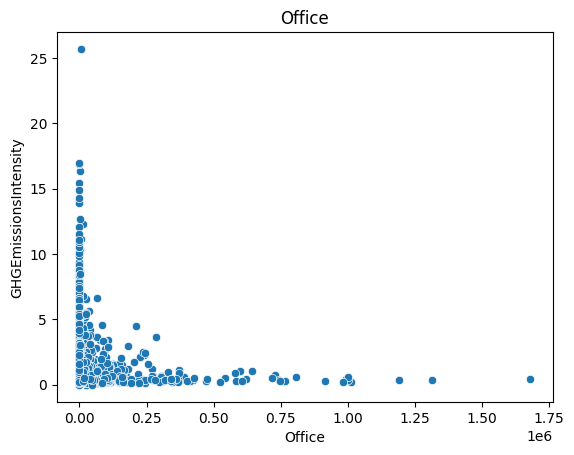

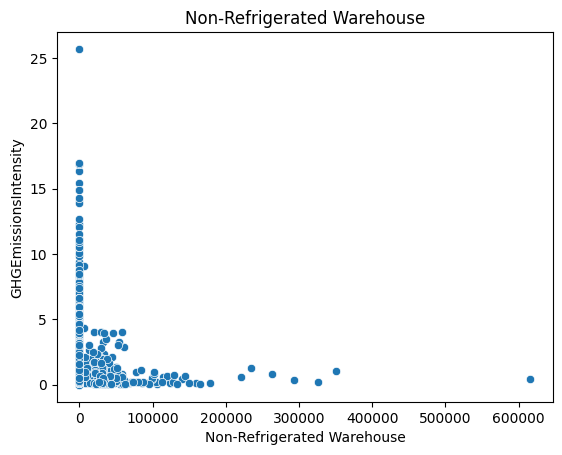

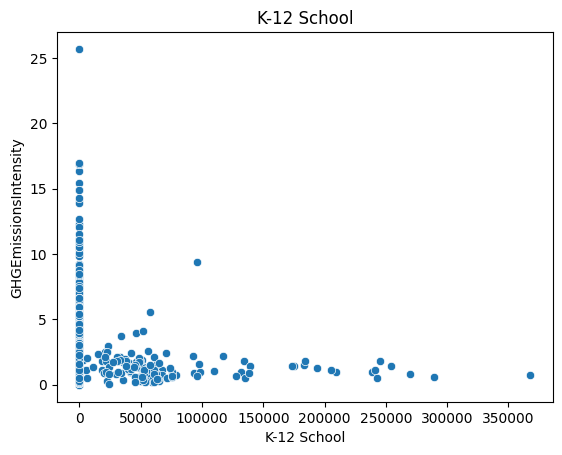

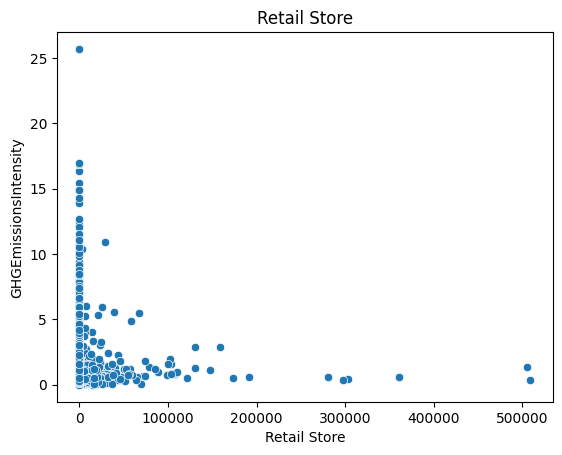

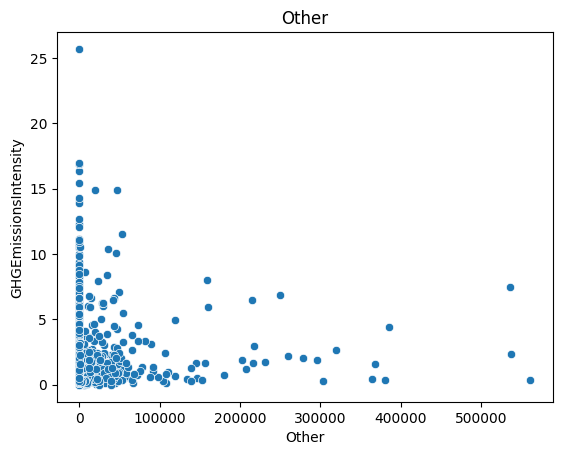

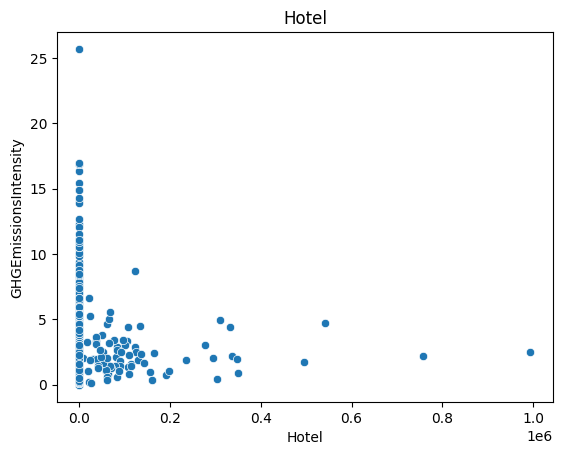

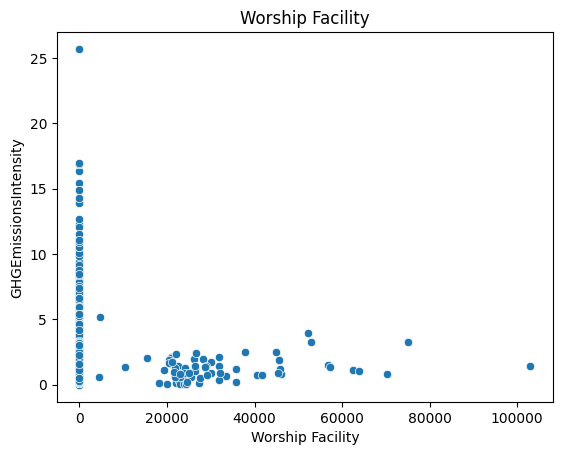

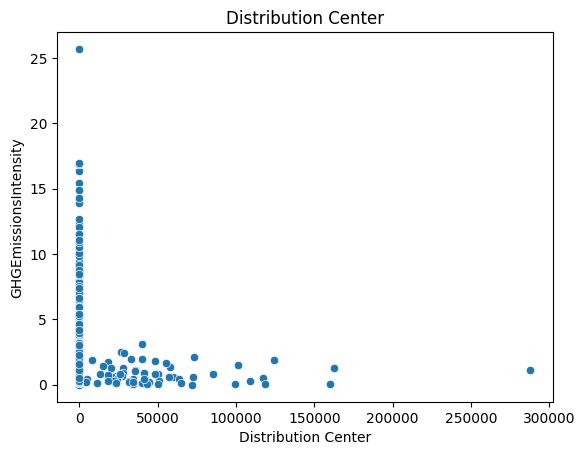

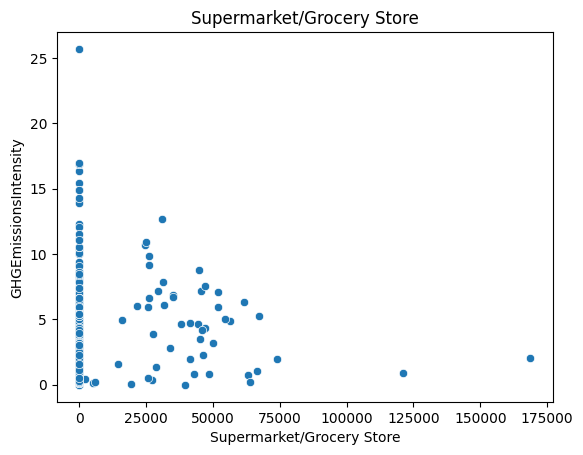

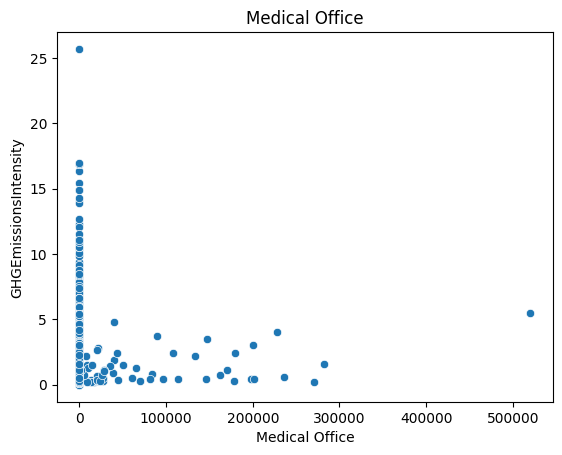

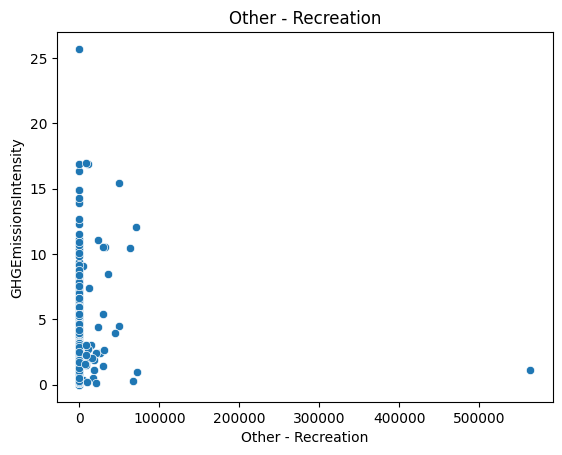

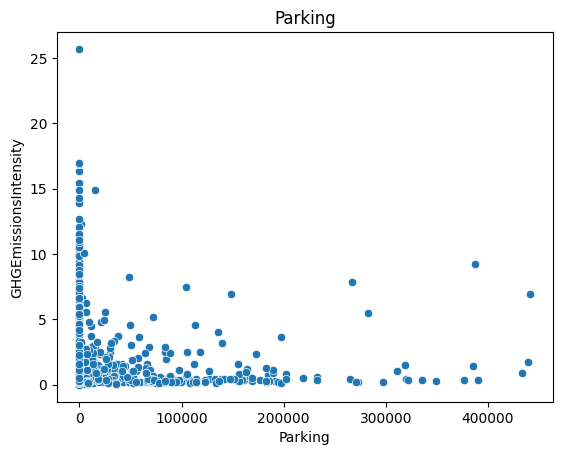

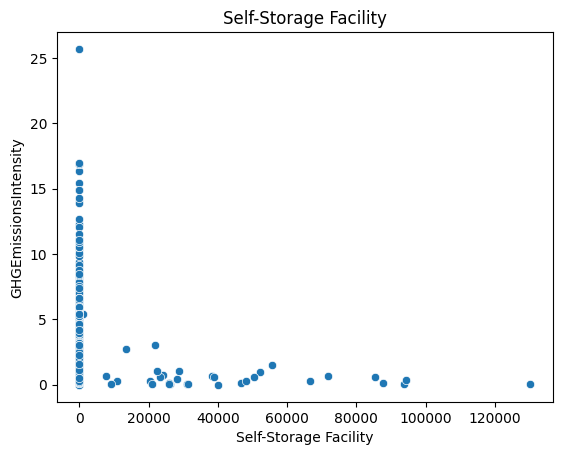

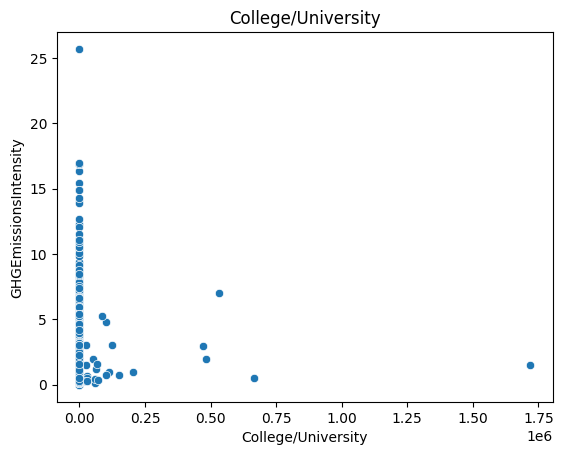

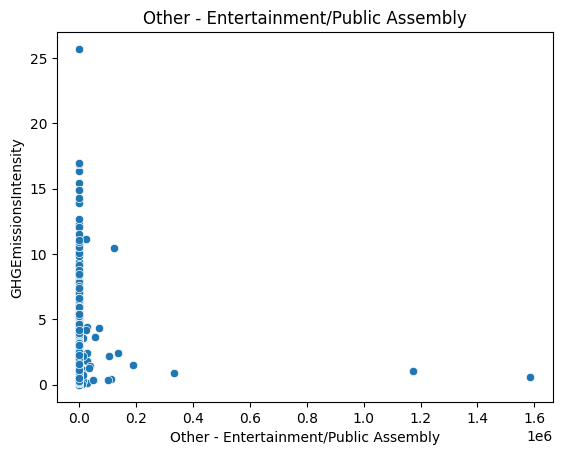

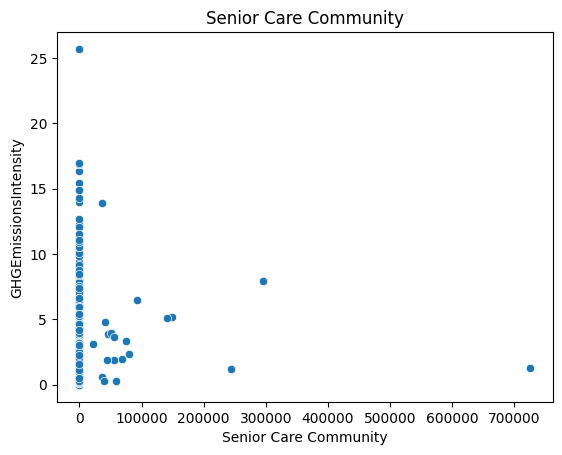

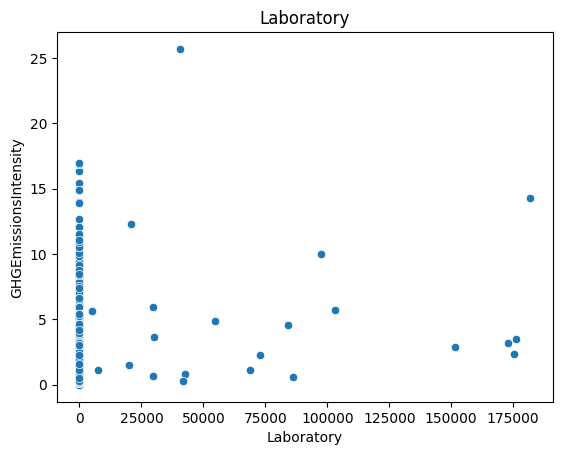

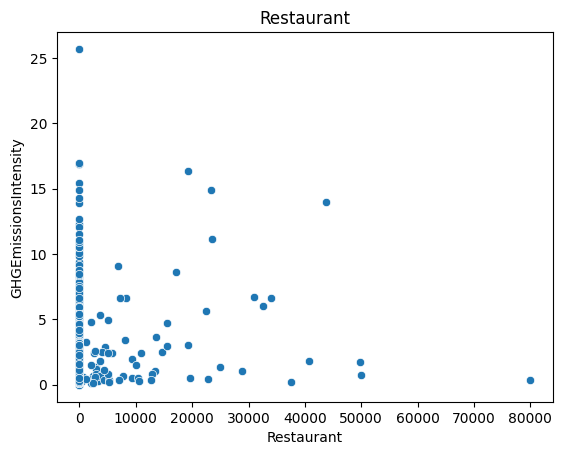

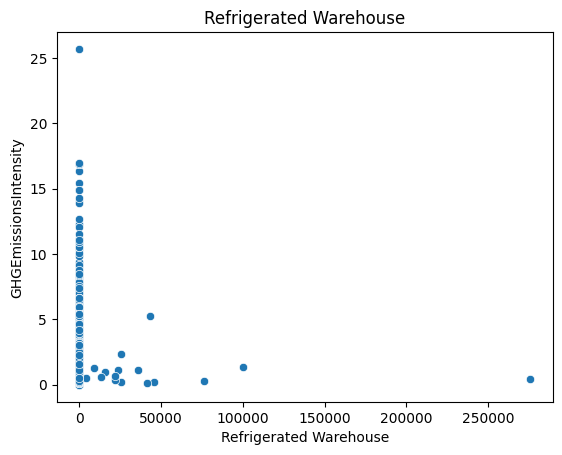

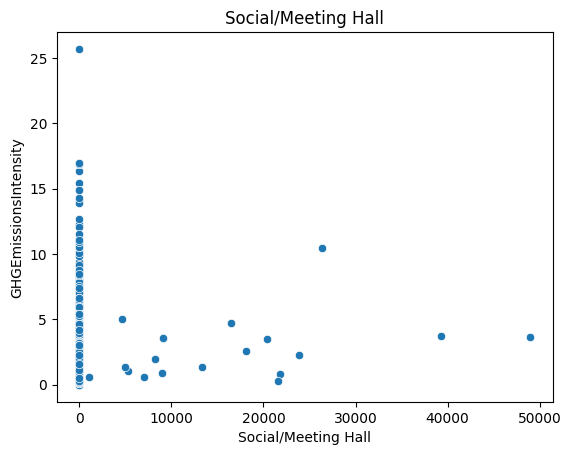

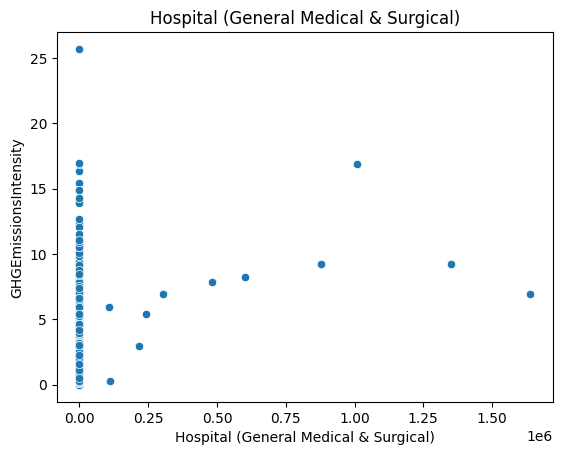

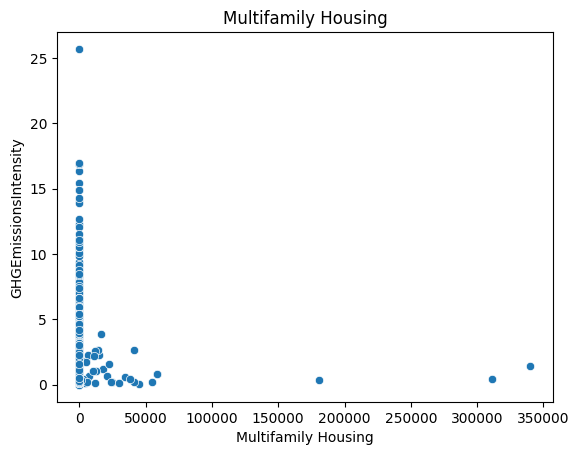

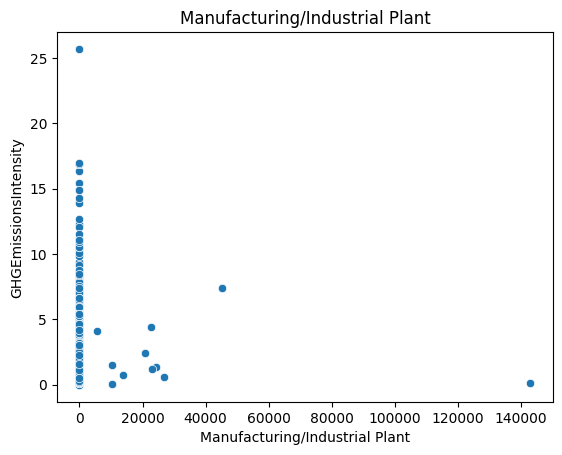

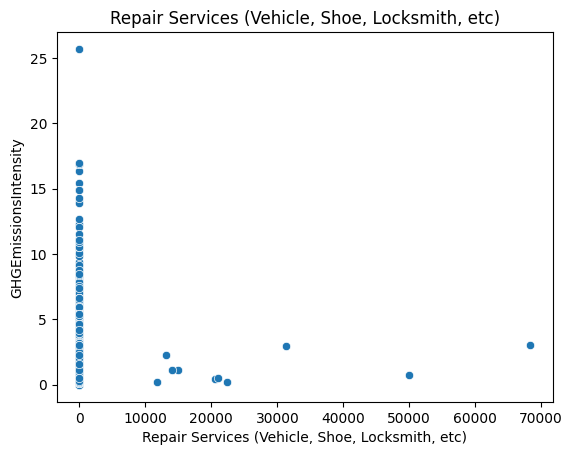

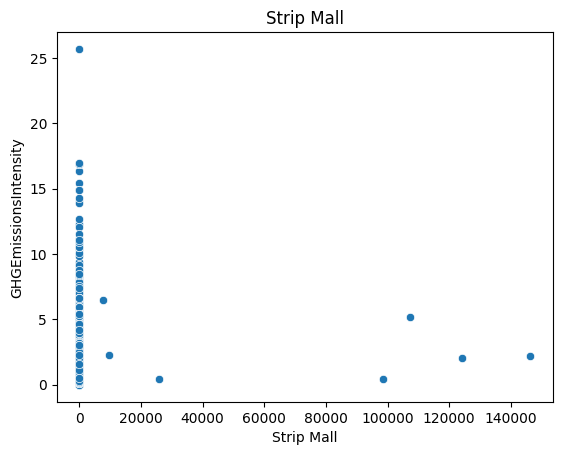

In [109]:
for col in list_type : 
    scatter_test(col,'GHGEmissionsIntensity')

# 2. OLS 

In [110]:
def format_col(str):
    """
    Formate les colonnes du dataframe
    """
    str = str.replace("""'""","")
    str = str.replace("""\n""","")
    str = str.replace("""/""","")
    str = str.replace(""" ""","_")
    str = str.replace("-","_")
    str = str.replace("(","")
    str = str.replace(")","")
    str = str.replace(",","_")
    str = str.replace("&","and")
    return str

In [111]:
def ols_auto(df_ols,list_cols,target,return_last_arg1=False):
    """
    df : DataFrame cleaned up ( no NaN and categorical must be encoded)
    list_cols : List of columns  ex : list(df_ols.columns)
    target : String of the col target ex:  'target'
    return_last_arg1 : renvoi du dernier arg1 (str) pour peaufiner l'anova
    """
    # conversion en liste
    if type(list_cols) != list :
      try:
        list_cols_asList = list(list_cols)
      except:
        print("Le second argument n'est pas convertissable en Liste Python ! ")
    else:
      list_cols_asList = list_cols.copy()

    # définition du df de travail
    df_test = df_ols[list_cols_asList].copy()
    
    # conversion en float des colonnes concernées
    for col in df_test.columns:
        try:
            df_test.loc[:,col] = df_test[col].astype(float,errors='ignore')
        except: # !!!  fonctionnalité d'erreur non testée pas testée
            print('Error : could not convert column : ',col,' to float')
    while True :
        # A REVOIR :  pour retirer un élément à chaque itération  ( utiliser regex ou autre ? )
        # construction de l'argument 1 ( chaine de caractere) dans la fonction ols
        str2=""
        for col in list_cols_asList :
            if col == target:
                pass
            else:
                str2+= (" + " + col )
        format_str= str2[2:]
        ols_arg1 = target +" ~ "+format_str + " -1 "
        # realisation de l'ols
        test_reg = ols(ols_arg1, data=df_test).fit()
        #print(i,test_reg.pvalues.idxmax(),test_reg.pvalues.max())
        # si p value max est inférieure à 5 % , break
        if  test_reg.pvalues.max() < 0.05:
            break
        else:
            list_cols_asList.remove(test_reg.pvalues.idxmax())
    if return_last_arg1 :
      return test_reg, ols_arg1
    return test_reg

In [167]:
ols_df = df.copy()
ols_df = pd.get_dummies(ols_df, columns=['Neighborhood'], drop_first=True)
# cols unusable
cols_unusable = ['YearBuilt','BuildingType','PrimaryPropertyType','SiteEUIWN(kBtu/sf)','LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA','PropertyGFATotal','PropertyGFAParking','ListOfAllPropertyUseTypes','SiteEUI(kBtu/sf)','SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)','Latitude', 'Longitude','SiteEnergyUse(kBtu)', 'SteamUse(kBtu)','Electricity(kWh)','Electricity(kBtu)','NaturalGas(therms)','NaturalGas(kBtu)','ComplianceStatus','GHGEmissionsIntensity']
ols_df.drop(columns=cols_unusable, inplace=True)
# renaming columns to perform ols
for col in ols_df.columns:
    col_formatted = format_col(col)
    ols_df.rename(columns={col:col_formatted},inplace=True)

### 2.1 GHG : Anova

['Neighborhood','BuildingType', 'PrimaryPropertyType','YearBuilt', 'NumberofBuildings',
       'NumberofFloors',
       'PropertyGFABuilding(s)',
       'ComplianceStatus',
       'Outlier']

In [168]:
olsGHG_df = ols_df.copy()
#manually drop the SiteEnergyUsekBtu
olsGHG_df.drop(columns=['SiteEnergyUseWNkBtu'], inplace=True)

In [169]:
GHG_reg, arg1 = ols_auto(olsGHG_df,olsGHG_df.columns,'TotalGHGEmissions', return_last_arg1=True)
print(GHG_reg.summary())

                                 OLS Regression Results                                
Dep. Variable:      TotalGHGEmissions   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.910
Method:                 Least Squares   F-statistic:                              916.3
Date:                Thu, 03 Aug 2023   Prob (F-statistic):                        0.00
Time:                        15:04:53   Log-Likelihood:                         -10726.
No. Observations:                1623   AIC:                                  2.149e+04
Df Residuals:                    1605   BIC:                                  2.158e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------

In [170]:
arg1[20:-3].replace('+',"','")

" NumberofBuildings ',' PropertyGFABuildings ',' is_campus ',' p_gas ',' p_elec ',' p_steam ',' WN_ratio ',' Data_Center ',' Other ',' Hotel ',' SupermarketGrocery_Store ',' Medical_Office ',' Other___Recreation ',' CollegeUniversity ',' Other___EntertainmentPublic_Assembly ',' Senior_Care_Community ',' Laboratory ',' Hospital_General_Medical_and_Surgical "

## 2.2 SiteEnergyUse(kBtu) : Anova

In [206]:
ols_energy_df = ols_df.copy()
ols_energy_df.drop(columns=['TotalGHGEmissions','p_gas','p_elec','p_steam'], inplace = True)

In [207]:
energy_reg, arg_energy = ols_auto(ols_energy_df,ols_energy_df.columns,'SiteEnergyUseWNkBtu',return_last_arg1=True)
print(energy_reg.summary())

                                 OLS Regression Results                                 
Dep. Variable:     SiteEnergyUseWNkBtu   R-squared (uncentered):                   0.905
Model:                             OLS   Adj. R-squared (uncentered):              0.903
Method:                  Least Squares   F-statistic:                              607.3
Date:                 Thu, 03 Aug 2023   Prob (F-statistic):                        0.00
Time:                         15:22:16   Log-Likelihood:                         -27738.
No. Observations:                 1623   AIC:                                  5.553e+04
Df Residuals:                     1598   BIC:                                  5.566e+04
Df Model:                           25                                                  
Covariance Type:             nonrobust                                                  
                                            coef    std err          t      P>|t|      [0.025      0.975]
----

In [208]:
arg_energy[22:-3].replace('+',"','")

" NumberofBuildings ',' skyscraper ',' is_campus ',' decennie ',' Data_Center ',' Office ',' Non_Refrigerated_Warehouse ',' K_12_School ',' Retail_Store ',' Other ',' Hotel ',' Distribution_Center ',' SupermarketGrocery_Store ',' Medical_Office ',' Other___Recreation ',' CollegeUniversity ',' Other___EntertainmentPublic_Assembly ',' Senior_Care_Community ',' Laboratory ',' Restaurant ',' Refrigerated_Warehouse ',' SocialMeeting_Hall ',' Hospital_General_Medical_and_Surgical ',' Multifamily_Housing ',' Strip_Mall "

# 3. TotalGHGEmissions : Prediction

In [193]:
possible_features = ['NumberofBuildings ',' PropertyGFABuildings ',' is_campus ',' p_gas ',' p_elec ',' p_steam ',' WN_ratio ',' Data_Center ',' Other ',' Hotel ',' SupermarketGrocery_Store ',' Medical_Office ',' Other___Recreation ',' Senior_Care_Community ',' Laboratory ',' Hospital_General_Medical_and_Surgical']
i = 0 
while i < len(possible_features):
    possible_features[i] = possible_features[i].strip()
    i+=1
possible_features

['NumberofBuildings',
 'PropertyGFABuildings',
 'is_campus',
 'p_gas',
 'p_elec',
 'p_steam',
 'WN_ratio',
 'Data_Center',
 'Other',
 'Hotel',
 'SupermarketGrocery_Store',
 'Medical_Office',
 'Other___Recreation',
 'Senior_Care_Community',
 'Laboratory',
 'Hospital_General_Medical_and_Surgical']

In [201]:
features = ['NumberofBuildings' , 'NumberofFloors' , 'is_laboratory' , 'is_hospital' , 'p_gas' , 'p_steam' , 'PropertyGFABuildings' , 'LargestPropertyUseType_SupermarketGrocery_Store' , 'LargestPropertyUseType_Senior_Care_Community' ,'LargestPropertyUseType_Data_Center' , 'LargestPropertyUseType_Hotel']
# a corriger
X_GHG = ols_df[possible_features].to_numpy()
y_GHG = ols_df['TotalGHGEmissions'].to_numpy()
X_train_GHG, X_test_GHG , y_train_GHG, y_test_GHG = train_test_split(X_GHG,y_GHG,test_size=0.2, random_state=33)

In [202]:
rf = RandomForestRegressor()
param_rf = {'n_estimators':[i for i in range(1,20,1)],
           'max_depth':[i for i in range(1,10,1)]}
regr = GridSearchCV(rf,param_grid=param_rf,scoring='r2',cv=5,refit=True)
regr.fit(X_train_GHG,y_train_GHG)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19]},
             scoring='r2')

In [203]:
regr.score(X_train_GHG,y_train_GHG)

0.9645405355887954

In [204]:
params = regr.best_params_
params

{'max_depth': 9, 'n_estimators': 18}

In [205]:
final_rf = RandomForestRegressor(n_estimators = params['n_estimators'],max_depth=params['max_depth'])
final_rf.fit(X_train_GHG,y_train_GHG)
metrics.r2_score(y_test_GHG,final_rf.predict(X_test_GHG))

0.7872250169975095

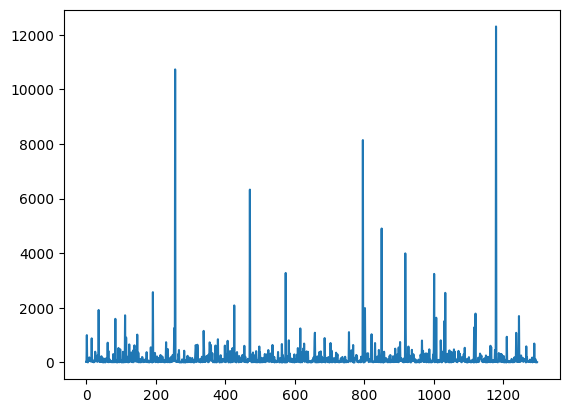

In [199]:
plt.plot(y_train_GHG)

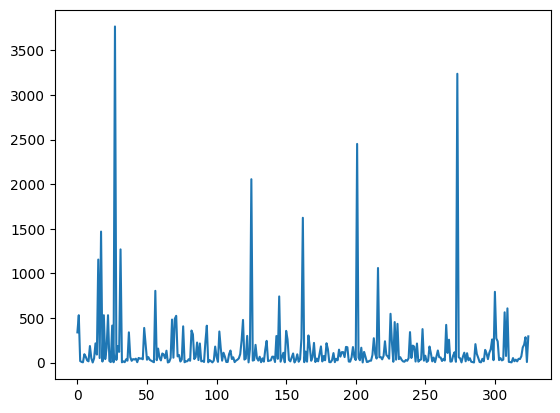

In [200]:
plt.plot(y_test_GHG)

# 4. SiteEnergyUsekBtu : Prediction

In [225]:
possible_features_E = ['NumberofBuildings ',' skyscraper ',' is_campus ',' decennie ',' Data_Center ',' Office ',' Non_Refrigerated_Warehouse ',' K_12_School ',' Retail_Store ',' Other ',' Hotel ',' Distribution_Center ',' SupermarketGrocery_Store ',' Medical_Office ',' Other___Recreation ',' CollegeUniversity ',' Other___EntertainmentPublic_Assembly ',' Senior_Care_Community ',' Laboratory ',' Restaurant ',' Refrigerated_Warehouse ',' SocialMeeting_Hall ',' Hospital_General_Medical_and_Surgical ',' Multifamily_Housing ',' Strip_Mall' ]
i = 0 
while i < len(possible_features_E):
    possible_features_E[i] = possible_features_E[i].strip()
    i+=1

In [238]:
#features = ['WN_ratio', 'YearBuilt' ,'NumberofBuildings', 'is_laboratory','LargestPropertyUseType_Hospital_General_Medical_and_Surgical', 'is_campus' , 'PropertyGFABuildings' , 'LargestPropertyUseType_SupermarketGrocery_Store','LargestPropertyUseType_Data_Center' , 'LargestPropertyUseType_Hotel']
# a corriger
X_energy = ols_df[possible_features_E]
y_energy = ols_df['SiteEnergyUseWNkBtu']

In [255]:
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression



plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs



def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


In [241]:
X_scaled = (X_energy - X_energy.mean(axis=0)) / X_energy.std(axis=0)

In [248]:
X_pca.shape[1]

25

In [251]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
"""
# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(0,X_pca.shape[1])]
X_pca_df = pd.DataFrame(X_pca, columns=component_names)"""

X_pca.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24
0,-1.067678,-1.922449,0.326349,0.099719,1.920935,0.365665,-0.506826,0.179226,-0.151525,-0.418225,...,0.171359,0.164561,-0.975462,-0.619828,0.596060,1.358644,0.218781,-0.117493,-0.202282,-1.678068
1,-1.199454,-2.502094,0.409814,-0.214955,1.184129,-0.130580,0.507948,0.247264,-0.486251,-0.059209,...,-0.004053,-0.245038,-0.760857,-1.100512,0.235200,-0.204894,0.083204,0.045025,-0.264625,-2.055773
2,-2.913759,-5.608732,0.892862,-1.607238,10.382110,-0.914137,3.363090,1.650280,-1.688544,-1.152115,...,-0.347676,1.236510,-3.898685,-6.926231,5.255188,0.784510,-0.274249,-0.639857,0.417614,3.102613
3,-0.995603,-1.783061,0.305856,0.148156,1.560886,0.407336,-0.647862,0.119038,-0.092296,-0.381432,...,0.191477,0.116286,-0.847237,-0.372767,0.415474,1.352427,0.238115,-0.092321,-0.228655,-1.877886
4,-1.266110,-2.480317,0.445188,-0.733103,1.770778,-0.067747,0.267699,0.239091,-0.344537,-0.206773,...,0.110337,0.050654,-0.786868,-1.267495,1.143759,0.275724,0.168836,-0.003215,-0.213084,-1.633983


In [253]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X_energy.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
NumberofBuildings,0.535367,-0.201991,0.101041,-0.093473,-0.042512,0.248972,0.130427,-0.016868,0.000238,-0.019114,...,-0.003029,0.008901,0.033217,-0.019606,0.008884,0.106571,-0.374869,-0.090525,0.631826,-0.099081
skyscraper,-0.236450,-0.589787,0.168719,-0.040624,0.082285,0.059019,-0.140885,-0.006680,-0.017455,-0.020112,...,0.060133,-0.049938,-0.044629,-0.074745,0.016635,0.262400,0.080674,-0.053735,-0.112425,-0.650335
is_campus,0.551583,-0.172969,0.016207,0.028232,0.054580,-0.260409,-0.123407,0.009108,0.000884,0.030180,...,-0.002547,-0.024596,0.027601,-0.007271,0.051475,0.055733,-0.413014,0.070477,-0.626535,0.045241
decennie,-0.057123,-0.204866,0.050081,-0.417598,-0.333455,-0.205799,0.321170,-0.009678,-0.063177,0.140393,...,-0.018999,-0.095548,0.192008,-0.178174,0.170512,-0.591446,-0.013542,0.079577,-0.024318,-0.115981
Data_Center,-0.045907,-0.080605,0.021750,-0.054516,-0.096886,0.025608,-0.240142,-0.219783,0.034572,0.145275,...,-0.110623,0.111115,0.137938,-0.097882,-0.028110,0.041200,0.001802,-0.023947,-0.002072,0.033207
Office,-0.219423,-0.491708,0.202881,0.025765,-0.241736,0.010081,-0.291402,-0.160076,0.044917,0.088692,...,-0.004648,-0.039268,-0.033071,0.093965,-0.170448,-0.001198,-0.101191,-0.022603,0.079142,0.594163
Non_Refrigerated_Warehouse,-0.003523,0.232133,0.653833,0.018182,-0.002447,-0.047031,0.035670,0.007417,-0.013530,0.060086,...,-0.000817,0.010077,-0.013692,0.018059,0.021040,-0.095626,-0.020718,-0.690239,-0.109439,-0.018956
K_12_School,0.019794,0.100442,-0.147110,-0.231735,-0.097765,-0.183388,0.034547,-0.263903,-0.630701,0.034388,...,0.036121,-0.084826,0.169744,-0.243594,-0.218925,0.353832,0.062746,-0.123813,0.002454,0.047890
Retail_Store,-0.019344,-0.022526,0.005842,0.358620,-0.159496,-0.062641,0.088589,-0.140387,0.313688,-0.131707,...,0.034697,0.490436,0.387527,-0.471108,-0.012411,0.006108,-0.009158,0.018959,-0.001101,-0.027207
Other,0.107777,-0.214589,0.000303,0.430945,-0.247324,-0.083430,0.336868,0.084382,-0.133858,-0.013161,...,0.007356,-0.201191,0.189447,0.224356,0.441644,0.257520,0.308967,-0.079855,-0.010689,0.139760


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

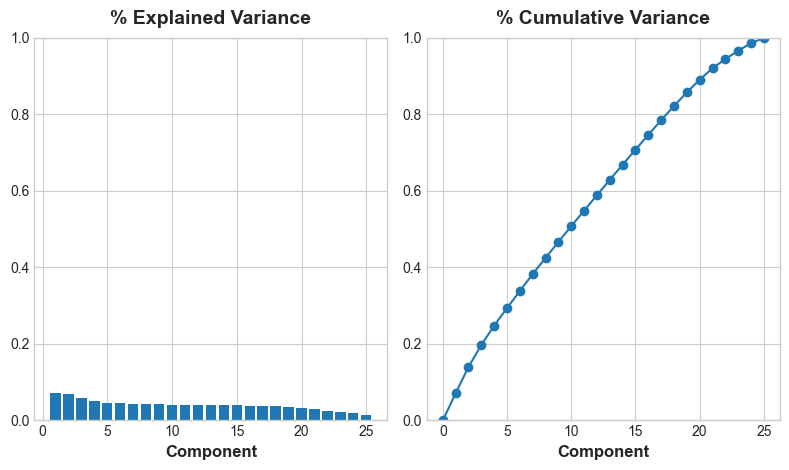

In [256]:
plot_variance(pca)

In [258]:
mi_scores = make_mi_scores(X_pca, y_energy, discrete_features=False)
mi_scores

pca14    0.367768
pca0     0.345402
pca1     0.308524
pca7     0.287191
pca24    0.271562
pca4     0.263751
pca11    0.231169
pca6     0.221927
pca21    0.221245
pca15    0.189593
pca17    0.180377
pca19    0.171274
pca9     0.168310
pca2     0.164679
pca16    0.163357
pca13    0.162120
pca10    0.156103
pca3     0.155964
pca18    0.145345
pca12    0.128932
pca5     0.128633
pca20    0.126592
pca8     0.117167
pca22    0.102189
pca23    0.096973
Name: MI Scores, dtype: float64

In [274]:
# ajout de pca14 à X_energy
X_energy['pca14'] =X_pca['pca14'].values

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_4044\559444632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_energy['pca14'] =X_pca['pca14'].values
C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_4044\559444632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_energy['pca0'] =X_pca['pca0'].values


## 4.1 train test séparation

In [363]:
X_train_energy, X_test_energy , y_train_energy, y_test_energy = train_test_split(X_energy,y_energy,test_size=0.2, random_state=12)

## 4.2 target encoding

In [364]:
from category_encoders import MEstimateEncoder

# Create the encoder instance. Choose m to control noise.
encoder = MEstimateEncoder(cols=["NumberofBuildings"], m=5.0)

# Fit the encoder on the encoding split.
encoder.fit(X_train_energy, y_train_energy)

# Encode the Zipcode column to create the final training data
X_train_energy_encoded = encoder.transform(X_train_energy)
X_test_energy_encoded = encoder.transform(X_test_energy)

## 4.3 model et predictions

In [365]:
rf = RandomForestRegressor()
param_rf = {'n_estimators':[i for i in range(1,20,1)],
           'max_depth':[i for i in range(1,10,1)]}
regr = GridSearchCV(rf,param_grid=param_rf,scoring='r2',cv=5,refit=True)
regr.fit(X_train_energy_encoded,y_train_energy)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19]},
             scoring='r2')

In [359]:
# rs = 12 : 0.7164 ( sans target & pca14); 0.73 avec (NumberofBuildings encoded)
# rs = 20 : 0.36 ( "decennie + nbr buildings") , 0.41
# rs = 42 : 0.57( sans target & pca14), 0.62(pca14), 0.632(target + pca 14)

In [366]:
regr.score(X_train_energy_encoded,y_train_energy)

0.9360432390335544

In [367]:
params = regr.best_params_
params

{'max_depth': 9, 'n_estimators': 17}

In [368]:
final_rf = RandomForestRegressor(n_estimators = params['n_estimators'],max_depth=params['max_depth'])
final_rf.fit(X_train_energy_encoded,y_train_energy)
metrics.r2_score(y_test_energy,final_rf.predict(X_test_energy_encoded))

0.7336883888651551

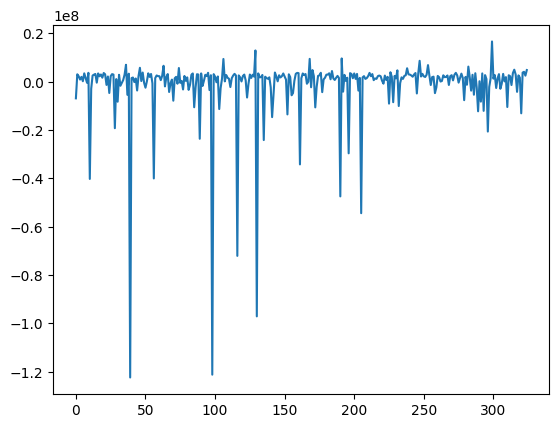

In [232]:
res_energy = pd.DataFrame(y_test_energy)
res_energy['preds'] = final_rf.predict(X_test_energy)
res_energy['diff'] = res_energy.apply(lambda x : x['preds'] - x[0] , axis =1 )
plt.plot(res_energy['diff'])

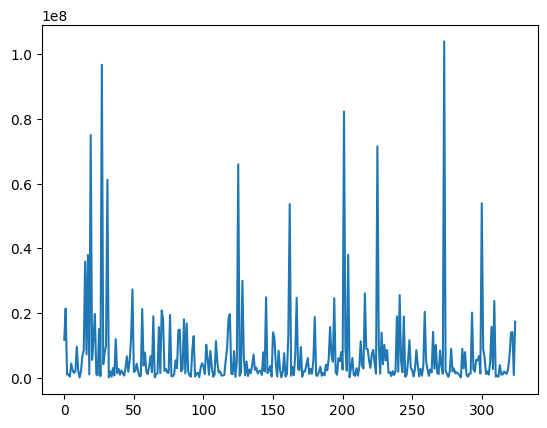

In [216]:
plt.plot(y_test_energy)

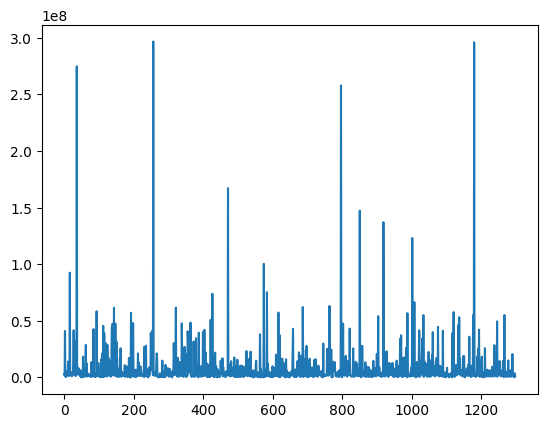

In [217]:
plt.plot(y_train_energy)